# Extraction of CKM Angle $\gamma$ from $B \to DK$ Decays

## Overview

This notebook implements a complete analysis pipeline for extracting the CKM (Cabibbo-Kobayashi-Maskawa) angle $\gamma$ and related $B$ meson parameters from interference patterns in $D$ meson decays. The method exploits the quantum interference between $b \to c\bar{u}s$ and $b \to u\bar{c}s$ amplitudes in $B^{\pm} \to DK^{\pm}$ decays, where the $D$ meson decays to the self-conjugate final state $K_S \pi^+ \pi^-$.

### Physics Motivation

The CKM angle $\gamma \equiv \arg(-V_{ud}V_{ub}^*/V_{cd}V_{cb}^*)$ is a fundamental parameter of the Standard Model, related to CP violation in quark mixing. It can be measured cleanly using tree-level $B$ decays with minimal theoretical uncertainty.

### Key Parameters Extracted

- **$\gamma$**: The weak phase (CKM angle)
- **$\delta_B$**: The strong phase difference between $B$ decay amplitudes  
- **$r_B = |A(B^- \to \bar{D}^0 K^-)/A(B^- \to D^0 K^-)|$**: The magnitude ratio of suppressed to favored $B$ decay amplitudes

### Method: GGSZ Approach

The **Giri-Grossman-Soffer-Zupan (GGSZ)** method uses the Dalitz plot distribution of $D \to K_S\pi^-\pi^+$ to access the phase information:

$$
\begin{align}
\mathcal{A}(B^- \to [K_S\pi\pi]_D K^-) &\propto A_D(s_{12}, s_{13}) + r_B e^{i(\delta_B - \gamma)} A_D(s_{13}, s_{12}) \\
\mathcal{A}(B^+ \to [K_S\pi\pi]_D K^+) &\propto A_D(s_{13}, s_{12}) + r_B e^{i(\delta_B + \gamma)} A_D(s_{12}, s_{13})
\end{align}
$$

where $A_D(s_{12}, s_{13})$ is the $D$ decay amplitude and $s_{ij} = (p_i + p_j)^2$ are the Dalitz variables with $p_1, p_2, p_3$ being the momenta of $K_S$, $\pi^-$, and
$\pi^+$ respectively.

### Workflow

1. **Setup**: Import libraries and define neural network architectures
2. **Amplitude Models**: Load trained normalizing flow models for flavor and even/odd CP eigenstates
3. **Normalization**: Compute $\Gamma_+$ and $\Gamma_-$ (CP-even/odd decay width)
4. **B Decay Simulation**: Generate pseudo-data with known $\gamma$, $\delta_B$, $r_B$
5. **Interference Terms**: Calculate $C$ and $S$ interference terms which encodes CP violation
6. **Parameter Extraction**: Fit the data to determine the desired parameters $r_B, \delta_B, \gamma$
7. **C Flow vs Exact**: plot C interference terms obtained from flow with the one obtained from isobar model

### References

- GGSZ Method: A. Giri et al., *Phys. Rev. D* **68**, 054018 (2003)
- Normalizing Flows: G. Papamakarios et al., *NeurIPS* (2017)


---
## BEFORE WE START: Square Dalitz Plot Coordinates

### What is the Square Dalitz Plot?

The **Square Dalitz Plot (SDP)** is a reparameterization of the traditional Dalitz plot $(s_{12}, s_{13})$ designed to:
1. **Uniform coverage**: Map the phase space to $[0,1] \times [0,1]$ square
2. **Simplify boundaries**: Replace irregular kinematic boundaries with a simple square
3. **Improve numerics**: Better suited for machine learning and integration

### Mathematical Transformation

The transformation from Dalitz plot coordinates to SDP is:

$$
\begin{align}
m' &= \frac{1}{\pi} \arccos\left(2\frac{s_{12} - s_{12}^{\min}}{s_{12}^{\max} - s_{12}^{\min}} - 1\right) \\
\theta' &= \frac{1}{\pi} \theta_{12}
\end{align}
$$

where $(m', \theta') \in [0,1]^2$ and $\theta_{12}$ is the helicity angle in the $(K_S, \pi^+)$ rest frame.

### Physical Interpretation

- **$m'$**: Rescaled invariant mass $s_{12}$ mapped to $[0,1]$ using arccos
- **$\theta'$**: Normalized helicity angle capturing angular distribution

The Jacobian of this transformation must be properly accounted for when converting probability densities:

$$
p_{DP}(s_{12}, s_{13}) = p_{SDP}(m', \theta') \cdot \left|\frac{\partial(m', \theta')}{\partial(s_{12}, s_{13})}\right|
$$

This coordinate system is particularly useful for:
- **Training normalizing flows** on a well-behaved domain
- **Numerical integration** with uniform grids
- **Avoiding edge effects** near kinematic boundaries

### Implementation

The `SquareDalitzPlot2` class from `Amplitude.py` provides:
- Forward transformation: `MpfromM(s12, s13, i, j, k)` and `TfromM(s12, s13, i, j, k)`
- Inverse transformation: `M_from_MpT(mp, th, i, j, k)`
- Jacobian calculation: `jacobian(s12, s13, i, j, k)`
- Kinematic boundary checking


---
## 1. Imports and Setup

Import required libraries for:
- Data manipulation (NumPy)
- Visualization (Matplotlib, Seaborn)
- Machine learning (PyTorch, normalizing flows)
- Optimization (iminuit for unbinned maximum likelihood fits)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

from iminuit import Minuit

---
## 2. Helper Functions for Coordinate Transformations

Define helper functions for working with Square Dalitz Plot coordinates and extracting amplitudes from normalizing flows.

**Coordinate transformations:**
- `dp_to_sdp`: Dalitz → Square Dalitz transformation
- `sdp_to_dp`: Square Dalitz → Dalitz transformation  
- `swap_to_other_pair_sdp`: Swap particle pair ordering (for CP conjugation)
- `sdp_uniform_mc`: Generate uniform MC in SDP

**Amplitude extraction:**
- `mag_AD_from_flow`: Extract $|A_D|$ from flow density (accounts for Jacobian)
- `_finite_pos`: Numerical stability helper

These functions handle the change of variables between coordinate systems and properly transform probability densities using Jacobians.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
from Amplitude import DKpp, BKpp, DalitzSample, AmpSample, SquareDalitzPlot2

# --- Particle masses ---
mD, mKs, mpi = 1.86483, 0.497611, 0.13957018
SDP = SquareDalitzPlot2(mD, mKs, mpi, mpi)

# ============================================================================
# Numerical Stability Helper
# ============================================================================

def _finite_pos(x, eps=1e-14):
    """
    Ensure array has finite positive values for numerical stability.
    """
    x = np.asarray(x)
    x = np.where(np.isfinite(x), x, 0.0)   # Replace NaN/±inf with 0
    return np.maximum(x, eps)              # Enforce minimum positive value

# ============================================================================
# Coordinate Transformation Functions
# ============================================================================

def dp_to_sdp(points_dp, sdp_obj, idx=(1,2,3)):
    """
    Convert Dalitz Plot coordinates to Square Dalitz Plot coordinates.
    """
    i, j, k = idx
    s12 = points_dp[:, 0]
    s13 = points_dp[:, 1]
    mp = np.vectorize(lambda a, b: sdp_obj.MpfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    tp = np.vectorize(lambda a, b: sdp_obj.TfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    return np.column_stack([mp, tp])

def sdp_to_dp(points_sdp, sdp_obj, idx=(1,2,3)):
    """
    Convert Square Dalitz Plot coordinates to Dalitz Plot coordinates.
    """
    i, j, k = idx
    out = np.empty_like(points_sdp, dtype=float)
    for n, (mp, th) in enumerate(points_sdp):
        sij, sik = sdp_obj.M_from_MpT(mp, th, i, j, k)
        out[n, 0] = sij
        out[n, 1] = sik
    return out  # columns: [s_ij, s_ik]

def swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2)):
    """
    Convert Dalitz point to SDP coordinates for a different particle pairing.
    
    Parameters
    ----------
    s12 : array_like
        Invariant mass squared s_{12} = (p_1 + p_2)^2.
    s13 : array_like
        Invariant mass squared s_{13} = (p_1 + p_3)^2.
    sdp_obj : SquareDalitzPlot2
        Square Dalitz plot object with transformation methods.
    pair_swap : tuple of int, optional
        New particle ordering (i, j, k). Default is (1, 3, 2) which
        swaps the roles of particles 2 and 3.
    
    Returns
    -------
    ndarray, shape (N, 2)
        SDP coordinates [m', theta'] for the swapped pairing.
    
    Notes
    -----
    This is used to compute |A_D(s_{13}, s_{12})| from a flow trained
    on |A_D(s_{12}, s_{13})|. The CP-conjugate amplitude corresponds
    to swapping the pi+ and pi- labels, which is equivalent to
    swapping s12 <-> s13.
    
    Example:
    If the flow is trained on (K_S pi-) vs (K_S pi+) [i.e., s12 vs s13],
    then to evaluate at the CP-conjugate point we need to query the
    flow at the SDP coordinates corresponding to (s13, s12).
    """
    i2, j2, k2 = pair_swap
    s12 = np.asarray(s12)
    s13 = np.asarray(s13)
    mp13 = np.empty_like(s12)
    th13 = np.empty_like(s12)
    for n in range(s12.size):
        mp13[n] = sdp_obj.MpfromM(s13[n], s12[n], i2, j2, k2)
        th13[n] = sdp_obj.TfromM(s13[n], s12[n], i2, j2, k2)
    return np.column_stack([mp13, th13])

def sdp_uniform_mc(N, eps=1e-6):
    """
    Generate uniform Monte Carlo points in Square Dalitz Plot coordinates.
    """
    return np.random.rand(N, 2) * (1 - 2*eps) + eps

# ============================================================================
# Amplitude Extraction from Normalizing Flows
# ============================================================================

def mag_AD_from_flow(points_sdp, flow, sdp_obj, idx=(1,2,3), device=None, tiny=1e-300):
    """
    Extract amplitude magnitude from normalizing flow probability density.
    
    Parameters
    ----------
    points_sdp : ndarray, shape (N, 2)
        Square Dalitz Plot points [m', theta'].
    flow : Flow
        Trained normalizing flow model representing p(m', theta') ∝ |A_D|^2.
    sdp_obj : SquareDalitzPlot2
        Square Dalitz plot transformation object.
    idx : tuple of int, optional
        Particle indices (i, j, k). Default is (1, 2, 3).
    device : torch.device, optional
        Device for PyTorch computation. If None, inferred from flow.
    tiny : float, optional
        Small number to prevent division by zero (default: 1e-300).
    
    Returns
    -------
    mag : ndarray, shape (N,)
        Amplitude magnitude |A_D(s_{ij}, s_{ik})| in Dalitz plot normalization.
    invJ : ndarray, shape (N,)
        Inverse Jacobian 1/|J| = 1/|∂(m',θ')/∂(s_{ij},s_{ik})|.
    
    **Implementation:**
    
    1. Evaluate flow density: p_SDP(m', θ') = exp(flow.log_prob(m', θ'))
    2. Transform (m', θ') -> (s_{ij}, s_{ik}) to get Dalitz coordinates
    3. Compute Jacobian J(s_{ij}, s_{ik}) of the transformation
    4. Return |A_D| = √(p_SDP · J) and inverse Jacobian 1/J
    
    The inverse Jacobian 1/J is also returned because it's needed for
    converting other probability densities between SDP and DP measures.
    
    """
    if device is None:
        device = next(flow.parameters()).device

    # Evaluate flow probability density in SDP coordinates
    import torch
    pts = torch.from_numpy(np.ascontiguousarray(points_sdp)).float().to(device)
    with torch.no_grad():
        logp = flow.log_prob(pts).cpu().numpy()
    p_sdp = np.exp(logp)

    # Transform each (m', θ') -> (s_ij, s_ik) and compute Jacobian
    u = points_sdp[:, 0]
    v = points_sdp[:, 1]
    sij = np.empty_like(u)
    sik = np.empty_like(u)
    
    for n, (uu, vv) in enumerate(points_sdp):
        s12, s13 = sdp_obj.M_from_MpT(uu, vv, *idx)
        sij[n], sik[n] = s12, s13

    # Compute Jacobian at each Dalitz point
    J = np.empty_like(u)
    for n in range(u.size):
        J[n] = float(sdp_obj.jacobian(sij[n], sik[n], *idx))

    # Extract DP-normalized amplitude magnitude
    # |A_D|² ∝ p_DP = p_SDP * J
    # |A_D| = √(p_SDP * J) = √(p_SDP / (1/J))
    mag = np.sqrt(p_sdp / np.maximum(1/J, tiny))
    
    return mag, 1/J


---
## 2. Neural Network Definitions

### Dalitz Dataset Class
PyTorch dataset wrapper for Dalitz plot points in Square Dalitz Plot (SDP) coordinates.


In [4]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset following PyTorch dataloader conventions.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

### Multi-Layer Perceptron (MLP)

The MLP is used as a transformation network within the normalizing flow. Key features:
- **SiLU (Swish) activation**: Provides smooth, non-monotonic activation for better gradient flow
- **Small output scale initialization**: Starts transformations near identity to aid training
- **Flexible architecture**: Configurable depth and width for expressiveness

The MLP parameterizes the bijective transformations in the spline-based normalizing flow.


In [5]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features,
                 hidden = 64, layers = 2, output_scale = 0.30):
        super().__init__()
        # Build a simple feed-forward network.
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        # Start logits near zero so spline softmax is well-behaved.
        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context = None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

### Normalizing Flow Constructor

Creates a normalizing flow model using **rational-quadratic neural spline** transforms:

**Key concepts:**
- **Normalizing flows**: Sequence of invertible transformations that map simple distributions (e.g., Gaussian) to complex target distributions
- **Spline flows**: Use piecewise rational-quadratic functions for flexible, monotonic transformations


**Architecture:**
- Multiple bijective coupling/autoregressive layers
- Each layer uses MLP to compute spline parameters
- Alternating transformation patterns to ensure expressiveness

These flows are trained to represent the decay density $p(m', \theta') \propto |A_D(m', \theta')|^2$ in Square Dalitz Plot coordinates.


In [6]:
def conjure_flow(on_unit_box = True, num_flows = 8, hidden_features = 64, num_bins = 8):
    dim = 2
    transforms = []
    if on_unit_box:
        # Use logit pre-transform to map (0,1) to R.
        transforms.append(InverseTransform(Sigmoid()))

    masks = [torch.tensor([1,0], dtype=torch.bool), torch.tensor([0,1], dtype = torch.bool)]
    for i in range(num_flows):
        mask = masks[i % 2]
        def conditioner(in_features, out_features, _hidden = hidden_features):
            return MLP(in_features, out_features, hidden = _hidden, layers = 2)
        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask                          = mask,
                transform_net_create_fn       = conditioner,
                num_bins                      = num_bins,
                tails                         = "linear",
                tail_bound                    = 5.0,
                apply_unconditional_transform = False,
            )
        )
        transforms.append(RandomPermutation(features = dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape = [dim])
    return Flow(transform, base)

### Initialize Amplitude Model and SDP Object

Create instances of:
- **DKpp**: $D \to K_S\pi\pi$ amplitude model (from `Amplitude.py`)
- **SquareDalitzPlot2**: SDP coordinate transformation object with particle masses


In [7]:
dkpp = DKpp()
sdp_obj  = SquareDalitzPlot2(dkpp.M(), dkpp.m1(), dkpp.m2(), dkpp.m3())

---
## 3. Load Trained Flows

We use **three separate normalizing flow models**, each serving a distinct purpose:

### The Three Flow Models

#### 1. Flavor Flow (`flow`)
- **Purpose**: Models the **total** $D \to K_S\pi\pi$ decay density
- **Learns**: $p(m', \theta') \propto |A_D(s_{12}, s_{13})|^2$
- **Usage**: Extracts amplitude **magnitudes** $|A_D|$ and $|\bar{A}_D|$ at any Dalitz point
- **Key role**: Provides the absolute normalization of the decay rate

#### 2. CP-Even Flow (`flow_even`)
- **Purpose**: Models the CP-even component of the amplitude
- **Learns**: $p_+(m', \theta') \propto |A_D(s_{12}, s_{13}) + A_D(s_{13}, s_{12})|^2$
- **Symmetry**: $A_+(s_{13}, s_{12}) = +A_+(s_{12}, s_{13})$ (symmetric under particle swap)
- **Usage**: Combined with CP-odd flow to extract **phase information** via $dC$ term

#### 3. CP-Odd Flow (`flow_odd`)
- **Purpose**: Models the CP-odd component of the amplitude
- **Learns**: $p_-(m', \theta') \propto |A_D(s_{12}, s_{13}) - A_D(s_{13}, s_{12})|^2$
- **Symmetry**: $A_-(s_{13}, s_{12}) = -A_-(s_{12}, s_{13})$ (antisymmetric under particle swap)
- **Usage**: Combined with CP-even flow to extract **phase information** via $dC$ term

### Why Three Separate Models?

The CP-even and CP-odd decomposition is crucial for extracting the relative **phase** between $A_D$ and $\bar{A}_D$:

$$
\begin{align}
A_D &= A_+ + A_- \\
\bar{A}_D &= A_+ - A_- \\
\end{align}
$$

The interference term that encodes CP violation is:

$$
\mathcal{C} = \text{Re}[A_D \bar{A}_D^*] = |A_+|^2 - |A_-|^2
$$

By learning $|A_+|^2$ and $|A_-|^2$ separately, we can reconstruct $dC$ without needing the complex phases of the individual resonances.

*Accounting for different decay widths*: 
$$
\mathcal{C} = \frac{1}{\Gamma}(\Gamma_+ \cdot p_{+} - \Gamma_- \cdot p_{-})
$$

where $p_{+}$, $p_{-}$ are the even and odd flow densities and $\Gamma = (\Gamma_+ + \Gamma_-)/2$ is the total decay width.

### Model Architecture

All three flows share the same architecture:
- **Type**: Rational-quadratic neural spline flows
- **Layers**: 12 coupling transforms with random permutations
- **Hidden units**: 128 per MLP
- **Bins**: 12-25 spline knots per dimension
- **Training data**: $10^6$ weighted events from physics-motivated isobar model

The models were trained separately on their respective target distributions to maximize likelihood.


### Load Flavor Flow Model

This flow learns the **total decay amplitude** $|A_D|^2$, combining all CP components.
It provides the baseline magnitude used for normalizing interference terms.


In [8]:
# Load the amplitude model

"""
--- MODEL 5 (The Champion)
# Hyperparameters
n_blocks = 12
n_bins = 25
hidden_features = 128

# Training details
batch_size = 50000
epochs = 130
scheduler: ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=3, min_lr=1e-6)
learning_rate_init = 0.009
patience = 3
factor = 0.9
min_learning_rate = 1e-6

NLL loss minimum (at the end of training): -1.253 (-1.254 global minimum during training)
Total parameters: 315768
"""

# Model hyperparameters
n_blocks = 12
n_bins = 25
hidden_features = 128

# Print total number of parameters
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total # of parameters: {total_params}")

# Initialize the model
flow = conjure_flow( num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

# Load the weights
flow.load_state_dict(torch.load('INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model_trial_1.pth'))

# Set the flow to evaluation mode
flow.eval()

Total # of parameters: 315768


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=74, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=74, bias=True)
        )
      )
      (4): Rand

### Load CP-Odd Flow Model

This flow learns the **antisymmetric** component: $|A_D - \bar{A}_D|^2$.


In [9]:
# Model hyperparameters
n_blocks = 12
n_bins = 12
hidden_features = 128

# Initialize the model
flow_odd = conjure_flow( num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

# Print total number of parameters
total_params = sum(p.numel() for p in flow_odd.parameters())
print(f"Total # of parameters: {total_params}")

# Load the weights
flow_odd.load_state_dict(torch.load('odd_12_12_128_1e6_trial_1.pth'))

# Set the flow to evaluation mode
flow_odd.eval()

Total # of parameters: 255396


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=35, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=35, bias=True)
        )
      )
      (4): Rand

### Load CP-Even Flow Model

This flow learns the **symmetric** component: $|A_D + \bar{A}_D|^2$.


In [10]:
# Model hyperparameters
n_blocks = 12
n_bins = 12
hidden_features = 128

# Initialize the model
flow_even = conjure_flow( num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

# Print total number of parameters
total_params = sum(p.numel() for p in flow_even.parameters())
print(f"Total # of parameters: {total_params}")

# Load the weights
flow_even.load_state_dict(torch.load('even_12_12_128_1e6_trial_1.pth'))

# Set the flow to evaluation mode
flow_even.eval()

Total # of parameters: 255396


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=35, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=35, bias=True)
        )
      )
      (4): Rand

---
## 6. Compute $\Gamma_+$ and $\Gamma_-$ (CP-Even/Odd Rates)

Calculate the partial decay width for the CP-even and CP-odd state of the D meson.

### Definitions

$$
\begin{align}
\Gamma_+ &= \int |A_D(s_{12}, s_{13}) + A_D(s_{13}, s_{12})|^2 \, ds_{12} ds_{13} \quad \text{(CP-even)} \\
\Gamma_- &= \int |A_D(s_{12}, s_{13}) - A_D(s_{13}, s_{12})|^2 \, ds_{12} ds_{13} \quad \text{(CP-odd)}
\end{align}
$$


### Computation Method

Integrate $|A_D \pm \overline{A_D}|^2$ over a dense grid in SDP coordinates:

1. Create $1000 \times 1000$ grid in $(m', \theta')$
2. Convert each point to DP coordinates $(s_{12}, s_{13})$
3. Evaluate amplitude magnitude $|A_D(s_{12}, s_{13}) \pm A_D(s_{13}, s_{12}) |^2$
4. Apply Jacobian factor for coordinate transformation
5. Sum over grid (with proper area weighting)

**Note**: The amplitude model `dkpp` gives the exact $A_D$ from an isobar model with the sum over resonances.


In [11]:

def compute_Gamma_pm_from_amplitude(dkpp_model, sdp_obj, 
                                    idx=(1,2,3), nx=1000, ny=1000):
    """
    Returns Gamma_plus, Gamma_minus computed from the amplitude model.
    """

    u = np.linspace(0, 1, nx)
    v = np.linspace(0, 1, ny)
    U, V = np.meshgrid(u, v, indexing='xy')
    pts_sdp = np.column_stack([U.ravel(), V.ravel()])

    # convert to DP (s12,s13)
    S = sdp_to_dp(pts_sdp, sdp_obj, idx=idx)
    s12 = S[:, 0]
    s13 = S[:, 1]

    # evaluate amplitudes
    A12  = dkpp_model.full(np.column_stack([s12, s13]))
    A13s = dkpp_model.full(np.column_stack([s13, s12]))

    # A±
    A_plus  = A12 + A13s
    A_minus = A12 - A13s

    mag12, invJ_here = mag_AD_from_flow(
        pts_sdp, flow, sdp_obj, idx=idx, device=device
    )

    # integrands
    I_plus  = np.abs(A_plus)**2  * invJ_here
    I_minus = np.abs(A_minus)**2 * invJ_here

    # integrate over grid
    du = 1.0/(nx-1)
    dv = 1.0/(ny-1)
    dA = du * dv

    Gamma_plus  = np.sum(I_plus)  * dA
    Gamma_minus = np.sum(I_minus) * dA

    return Gamma_plus, Gamma_minus


### Execute Computation



In [12]:
gamma_p, gamma_m = compute_Gamma_pm_from_amplitude(dkpp, sdp_obj, 
                                    idx=(1,2,3), nx=1000, ny=1000)

/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


In [13]:
print("Gamma_plus  =", gamma_p)
print("Gamma_minus =", gamma_m)

Gamma_plus  = 949.7815962083758
Gamma_minus = 2008.2159578060262


---
## 7. $B^{\pm}$ Decay Sample Generation

Generate simulated $B^+$ and $B^-$ decay samples using the GGSZ formalism.

### Physics Model

The decay rate for $B^- \to [K_S\pi\pi]_D K^-$ in the Dalitz plot is:

$$
\begin{align}
\frac{d^2\Gamma^-}{ds_{12} ds_{13}} &\propto |A_D(s_{12}, s_{13}) + r_B e^{i(\delta_B - \gamma)} A_D(s_{13}, s_{12})|^2 \\
&= |A_D|^2 + r_B^2 |\bar{A}_D|^2 + 2 r_B \text{Re}[A_D \bar{A}_D^* e^{i(\delta_B - \gamma)}]
\end{align}
$$

where:
- $A_D(s_{12}, s_{13}) \equiv A(D^0 \to K_S\pi^+\pi^-)$ at point $(s_{12}, s_{13})$
- $\bar{A}_D(s_{12}, s_{13}) \equiv A(\bar{D}^0 \to K_S\pi^+\pi^-) = A_D(s_{13}, s_{12})$ (CP conjugation swaps $\pi^+ \leftrightarrow \pi^-$)
- $r_B$: ratio of suppressed/favored amplitudes
- $\delta_B$: strong phase difference  
- $\gamma$: weak phase (CKM angle) - **this is what we want to measure!**

For $B^+$, replace $\gamma \to -\gamma$ (CP conjugation flips weak phase).

### Interference Terms

Expanding using $A_D = |A_D| e^{i\phi_D}$:

$$
\text{Re}[A_D \bar{A}_D^* e^{i(\delta_B - \gamma)}] = |A_D||\bar{A}_D| \cos(\phi_D - \phi_{\bar{D}} + \delta_B - \gamma)
$$

This interference term:
- Varies across the Dalitz plot (different $\phi_D$ at each point)
- Contains the $\gamma$ dependence we want to extract
- Causes **asymmetries** between $B^+$ and $B^-$ distributions

### Generation Method

The function `generate_BpBm_samples` uses **accept-reject sampling**:

1. Propose uniform random points in SDP
2. Compute acceptance probability from $|\mathcal{A}_{B^\pm}|^2$
3. Accept/reject based on probability
4. Repeat until desired number of events

**Outputs:**
- `dataM_sdp`, `dataP_sdp`: Experimental $B^-$, $B^+$ samples in SDP
- `mcM_sdp`, `mcP_sdp`: Uniform Monte Carlo for efficiency corrections
- Also DP versions: `dataM_dp`, `dataP_dp`, etc.


In [14]:
import time
def generate_BpBm_samples(
    rB, deltaB, gamma,
    num_exp_events,
    num_mc_events,
    SDP,
    idx=(1,2,3),
):
    """
    Generate simulated B- and B+ datasets in DP and SDP coordinates,
    along with uniform SDP Monte Carlo for both charges.

    Parameters
    ----------
    rB : float
        r_B value.
    deltaB : float (radians)
        Strong phase delta_B.
    gamma : float (radians)
        Weak phase gamma.
    num_exp_events : int
        Number of experimental events per charge.
    num_mc_events : int
        Number of MC events per charge.
    SDP : object
        Square Dalitz object used for mapping DP<->SDP.
    idx : tuple
        Dalitz variable ordering (default = (1,2,3)).

    Returns
    -------
    dict containing:
        dataM_dp, dataP_dp
        dataM_sdp, dataP_sdp
        mcM_sdp, mcP_sdp
    """

    # --- Create BKpp models for B− and B+ ---
    bkpp_true_M = BKpp(rB=rB, deltaB=deltaB, gamma=gamma, Bcharge=-1)
    bkpp_true_P = BKpp(rB=rB, deltaB=deltaB, gamma=gamma, Bcharge=+1)

    genM = AmpSample(bkpp_true_M)
    genP = AmpSample(bkpp_true_P)

    # --- Generate DP data ---
    print("Generating B− data (DP)…")
    t0 = time.time()
    dataM_dp = genM.generate(num_exp_events, nbatch=20_000)
    print(f"  done in {time.time()-t0:.2f}s, shape={dataM_dp.shape}")

    print("Generating B+ data (DP)…")
    t0 = time.time()
    dataP_dp = genP.generate(num_exp_events, nbatch=20_000)
    print(f"  done in {time.time()-t0:.2f}s, shape={dataP_dp.shape}")

    # --- DP → SDP ---
    print("Converting B− DP → SDP…")
    dataM_sdp = dp_to_sdp(dataM_dp, SDP, idx=idx)

    print("Converting B+ DP → SDP…")
    dataP_sdp = dp_to_sdp(dataP_dp, SDP, idx=idx)

    # --- Generate uniform SDP MC ---
    print("Generating MC for B− (SDP)…")
    t0 = time.time()
    mcM_sdp = sdp_uniform_mc(num_mc_events)
    print(f"  done in {time.time()-t0:.2f}s, shape={mcM_sdp.shape}")

    print("Generating MC for B+ (SDP)…")
    t0 = time.time()
    mcP_sdp = sdp_uniform_mc(num_mc_events)
    print(f"  done in {time.time()-t0:.2f}s, shape={mcP_sdp.shape}")

    return {
        "dataM_dp": dataM_dp,
        "dataP_dp": dataP_dp,
        "dataM_sdp": dataM_sdp,
        "dataP_sdp": dataP_sdp,
        "mcM_sdp": mcM_sdp,
        "mcP_sdp": mcP_sdp,
    }

---
## 8. Interference Term Calculation

Compute the interference terms $C$ and $S$ that encode CP violation.

### Decomposition of $B$ Decay Rates

The $B^{\pm}$ decay rates can be written as:

$$
\begin{align}
\mathcal{R}^-(m', \theta') &=  K(m', \theta') + r_B^2 K(m', \theta') \\
&\quad + 2r_B[\mathcal{C}(m', \theta') \cos(\delta_B - \gamma) - \mathcal{S}(m', \theta') \sin(\delta_B - \gamma)] \\
\\
\mathcal{R}^+(m', \theta') &=  K(m', \theta') + r_B^2  K(m', \theta') \\
&\quad + 2r_B[\mathcal{C}(m', \theta') \cos(\delta_B + \gamma) + \mathcal{S}(m', \theta') \sin(\delta_B + \gamma)]
\end{align}
$$

where $K(m', \theta') \equiv |A_D(m', \theta')|^2/\Gamma$.

### Interference Terms

The **cosine term** (real part of interference):

$$
C(m', \theta') = \text{Re}[A_D(m', \theta') \bar{A}_D^*(m', \theta')] = |A_D||\bar{A}_D| \cos(\phi_D - \phi_{\bar{D}})
$$

The **sine term** (imaginary part of interference):

$$
S(m', \theta') = \text{Im}[A_D(m', \theta') \bar{A}_D^*(m', \theta')] = |A_D||\bar{A}_D| \sin(\phi_D - \phi_{\bar{D}})
$$

### Obtain C Using Normalizing Flows


**Flow-based determination**: Use the learned normalized densities $f_+$, $f_-$ from the even/odd flows:

$$
\mathcal{C} = \frac{1}{\Gamma}(\Gamma_+ \cdot p_{+} - \Gamma_- \cdot p_{-})
$$

where:
- $p_+(m', \theta')$: CP-even flow density  
- $p_-(m', \theta')$: CP-odd flow density


### Function Details

`compute_interference_terms` computes:
- Magnitudes $|A_D|$ from flow densities
- Jacobians from coordinate transformations  
- Interference terms $\mathcal{C}$, $\mathcal{S}$ using normalizing flows 
- Properly handles numerical stability (avoid $\log(0)$, etc.)


In [103]:
def compute_interference_terms(points_sdp, flow_flavor, flow_even, flow_odd, 
                                dkpp_model, sdp_obj, Gamma_minus = 1, Gamma_plus = 1, 
                                  idx=(1,2,3), device=None):
        # (u,v) -> (s12,s13)
        dp = sdp_to_dp(points_sdp, sdp_obj, idx=idx)
        s12, s13 = dp[:,0], dp[:,1]

        # magnitudes (DP) + invJ from flavor flow
        mag12, invJ_here = mag_AD_from_flow(points_sdp, flow_flavor, sdp_obj, idx=idx, device=device)
        U13 = swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2))
        mag13, _ = mag_AD_from_flow(U13, flow_flavor, sdp_obj, idx=(1,3,2), device=device)

        # ensure finite/positive basics
        mag12  = _finite_pos(mag12)
        mag13  = _finite_pos(mag13)
        invJ_here = _finite_pos(invJ_here)
        J_here = invJ_here

        pF   = mag12**2
        pFsw = mag13**2
        abJ  = mag12 * mag13

        # C from even/odd flows in DP measure
        mag_even, _ = mag_AD_from_flow(points_sdp, flow_even, sdp_obj, idx=idx, device=device)
        mag_odd,  _ = mag_AD_from_flow(points_sdp, flow_odd,  sdp_obj, idx=idx, device=device)
        p_even = _finite_pos(mag_even)**2
        p_odd  = _finite_pos(mag_odd)**2
        C =  (Gamma_plus *p_even - Gamma_minus * p_odd)/ (Gamma_minus + Gamma_plus)

        
        A12  = dkpp_model.full(np.column_stack([s12, s13]))
        A13s = dkpp_model.full(np.column_stack([s13, s12]))
        phi12 = np.angle(A12)
        phi13 = np.angle(A13s)
        dphi  = (phi12 - phi13 + np.pi) % (2*np.pi) - np.pi
        signS = np.sign(np.sin(dphi))

        S = signS * np.sqrt(np.maximum(abJ*abJ - C*C, 0.0))

        # final safety for downstream logs
        pF   = _finite_pos(pF)
        pFsw = _finite_pos(pFsw)
        C   = np.where(np.isfinite(C), C, 0.0)
        S   = np.where(np.isfinite(S), S, 0.0)
        J_here = _finite_pos(J_here)

        return dict(pF=pF, pFsw=pFsw, C=C, S = S, abJ=abJ, J=J_here)


---
## 9. Parameter Extraction: Unbinned Maximum Likelihood Fit

Perform an **unbinned extended maximum likelihood (UEML) fit** to extract $r_B$, $\delta_B$, and $\gamma$.

### Likelihood Function

For $B^+$ and $B^-$ samples, the extended negative log-likelihood is:

$$
-\ln \mathcal{L} = N_+ + N_- - \sum_{i \in B^+} \ln p_+(m'_i, \theta'_i) - \sum_{j \in B^-} \ln p_-(m'_j, \theta'_j)
$$

where:
- $N_\pm = $ expected number of $B^\pm$ events (normalization)
- $p_\pm(m', \theta') = \mathcal{R}^\pm(m', \theta') / N_\pm$ are the normalized probability densities

### Normalization

The normalizations are computed via Monte Carlo integration:

$$
N_\pm = \int \mathcal{R}^\pm(m', \theta') \, dm' d\theta' \approx \frac{1}{N_{\text{MC}}} \sum_{k=1}^{N_{\text{MC}}} \mathcal{R}^\pm(m'_k, \theta'_k)
$$

using uniform MC samples $\{(m'_k, \theta'_k)\}$.

### Parameterization

To ensure valid ranges and improve convergence:

**1. $r_B$ (amplitude ratio):**
- Physical range: $r_B \in (0, 1)$, typically $r_B \sim 0.1$

**2. $\delta_B$, $\gamma$ (phases):**
- Physical range: $[0, 2\pi]$ (or equivalently $[-\pi, \pi]$)
- Periodic wrapping: Ensure phase is interpreted modulo $2\pi$
- Initial values offset from truth to test convergence

### Minimization Strategy

Use **iminuit** (Python wrapper for MINUIT2):
- **MINUIT**: Industry-standard minimizer developed at CERN
- Handles bounded parameters, parameter fixing, error calculation
- Computes Hessian matrix at minimum for uncertainties
- Reports parameter correlations

**Fitting procedure:**
1. Initialize parameters near expected values (with offsets to test robustness)
2. Compute $-\ln \mathcal{L}$ for given $(r_B, \delta_B, \gamma)$
3. Minimize using gradient-based methods (MIGRAD algorithm)
4. Estimate uncertainties from Hessian (HESSE algorithm)
5. Optionally run MINOS for asymmetric errors

### Fit Quality Checks

After fitting, check:
- **Convergence**: Did minimizer reach a valid minimum?
- **Covariance matrix**: Is it valid (positive definite)?  
- **Parameter values**: Are they physical and near true values?
- **Uncertainties**: Are they reasonable given sample size?
- **Correlations**: Are parameters strongly correlated? (expected for $\gamma$ and $\delta_B$)


In [16]:
def fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    dataM_sdp, dataP_sdp, mcM_sdp, mcP_sdp,
    flow_flavor, flow_even, flow_odd, dkpp_model,
    true_rB, true_deltaB, true_gamma,
    sdp_obj, idx=(1,2,3),
    initial_scale=0.2, delta_offset=30, gamma_offset=30,
    device=None, eps=1e-14,Gamma_minus = 1, Gamma_plus = 1, k= 1
):
    # ------------------------------------------------------------
    # Compute interference terms (raw dC, raw dS)
    # ------------------------------------------------------------
    tM = compute_interference_terms(dataM_sdp, flow_flavor, flow_even, flow_odd, dkpp_model, sdp_obj, Gamma_minus, Gamma_plus, idx, device)
    tP = compute_interference_terms(dataP_sdp, flow_flavor, flow_even, flow_odd, dkpp_model, sdp_obj, Gamma_minus, Gamma_plus, idx, device)
    mM = compute_interference_terms(mcM_sdp,   flow_flavor, flow_even, flow_odd, dkpp_model, sdp_obj, Gamma_minus, Gamma_plus, idx, device)
    mP = compute_interference_terms(mcP_sdp,   flow_flavor, flow_even, flow_odd, dkpp_model, sdp_obj, Gamma_minus, Gamma_plus, idx, device)

    # ------------------------------------------------------------
    # HARD CUT: keep only physical points |dC| <= abJ
    # ------------------------------------------------------------
    maskM  = (np.abs(tM['C']) <= tM['abJ'])
    maskMC = (np.abs(mM['C']) <= mM['abJ'])
    maskP  = (np.abs(tP['C']) <= tP['abJ'])
    maskPC = (np.abs(mP['C']) <= mP['abJ'])

    for key in tM:
        tM[key] = tM[key][maskM]
    for key in tP:
        tP[key] = tP[key][maskP]
    for key in mM:
        mM[key] = mM[key][maskMC]
    for key in mP:
        mP[key] = mP[key][maskPC]

    # updated sizes
    N_expM = maskM.sum()
    N_expP = maskP.sum()

    print(N_expM, N_expP)

    # ------------------------------------------------------------
    # Likelihood
    # ------------------------------------------------------------
    def nll(rB, delta, gamma):
        thM = np.radians(delta - gamma)
        thP = np.radians(delta + gamma)

        # data PDFs
        pBm_data = (tM['pFsw'] + rB*rB*tM['pF']
                    + 2*rB*(np.cos(thM)*tM['C'] - np.sin(thM)*tM['S']))

        pBp_data = (tP['pF']   + rB*rB*tP['pFsw']
                    + 2*rB*(np.cos(thP)*tP['C'] + np.sin(thP)*tP['S']))

        pBm_data = _finite_pos(pBm_data, eps)
        pBp_data = _finite_pos(pBp_data, eps)

        # MC normalization (SDP uniform → multiply by J)
        pBm_mc_arr = mM['J'] * (mM['pFsw'] + rB*rB*mM['pF']
                      + 2*rB*(np.cos(thM)*mM['C'] - np.sin(thM)*mM['S']))

        pBp_mc_arr = mP['J'] * (mP['pF']   + rB*rB*mP['pFsw']
                      + 2*rB*(np.cos(thP)*mP['C'] + np.sin(thP)*mP['S']))

        pBm_mc_mean = _finite_pos(pBm_mc_arr, eps).mean()
        pBp_mc_mean = _finite_pos(pBp_mc_arr, eps).mean()

        return (-np.log(pBm_data).sum() + N_expM*np.log(pBm_mc_mean)
                -np.log(pBp_data).sum() + N_expP*np.log(pBp_mc_mean))

    # ------------------------------------------------------------
    # Minuit setup
    # ------------------------------------------------------------
    init_rB    = true_rB * initial_scale
    init_delta = true_deltaB + delta_offset
    init_gamma = true_gamma  + gamma_offset

    m = Minuit(nll, rB=init_rB, delta=init_delta, gamma=init_gamma)
    m.limits['rB']    = (0, 1)
    m.limits['delta'] = (0, 360)
    m.limits['gamma'] = (0, 360)
    m.errors['rB']    = 0.01
    m.errors['delta'] = 2.0
    m.errors['gamma'] = 2.0
    m.errordef = Minuit.LIKELIHOOD

    
    t0 = time.time(); m.migrad(); m.hesse()
    print(f"Total fit time: {time.time()-t0:.2f}s\n")

    print(f"rB    = {m.values['rB']:.4f} ± {m.errors['rB']:.4f}")
    print(f"delta = {m.values['delta']:.2f}° ± {m.errors['delta']:.2f}°")
    print(f"gamma = {m.values['gamma']:.2f}° ± {m.errors['gamma']:.2f}°")
    print(f"(true rB={true_rB:.4f}, true γ={true_gamma:.2f}°, true δ={true_deltaB:.2f}°)")

    return m


---
## 10. Example Fits

Demonstrate the fitting procedure with generated pseudo-data.

### Test Case Configuration

**True physics parameters:**
- $\gamma = 70^\circ$ (CKM angle)
- $\delta_B = 130^\circ $(strong phase)
- $r_B = 0.1$ (amplitude ratio)

**Sample sizes:**
- $N_{\exp} = 50{,}000$ experimental events per charge (20,000 total)
- $N_{\text{MC}} = 500{,}000$ Monte Carlo events per charge (for normalization)

### Expected Statistical Uncertainties

The expected uncertainties scale as $\sim 1/\sqrt{N}$:


These are **statistical uncertainties only**. Systematic uncertainties (detector effects, backgrounds, model dependence) would be added in quadrature for a real measurement.

### Fit Initialization Strategy

To test robustness, we initialize the fit with **offsets from the true values**:

- $r_B^{\text{init}} = \text{true} \times (1 \pm 0.2)$ (20% offset)
- $\delta_B^{\text{init}} = \text{true} \pm 30^\circ$
- $\gamma^{\text{init}} = \text{true} \pm 30^\circ$

If the fit is well-behaved, it should converge to the true values regardless of initialization.


### Generate $B^\pm$ Samples


In [53]:
# ============================================================================
# Generate B+/B- samples with known physics parameters
# ============================================================================

# True physics parameters
true_gamma = 70.0 * np.pi / 180.0    # Weak phase (CKM angle) in radians
true_deltaB = 130.0 * np.pi / 180.0  # Strong phase in radians
true_rB = 0.1                         # Amplitude ratio

# Sample sizes
num_exp_events = 50000  # Experimental events per charge
num_mc_events = 500000   # Monte Carlo events per charge (for efficiency)

print(f"Generating samples with:")
print(f"  gamma = {true_gamma * 180 / np.pi:.1f} degrees")
print(f"  delta_B = {true_deltaB * 180 / np.pi:.1f} degrees")
print(f"  r_B = {true_rB:.3f}")
print(f"\nSample sizes:")
print(f"  Experimental events per charge: {num_exp_events}")
print(f"  Monte Carlo events per charge: {num_mc_events}")

# Generate the samples
results = generate_BpBm_samples(
    rB=true_rB,
    deltaB=true_deltaB,
    gamma=true_gamma,
    num_exp_events=num_exp_events,
    num_mc_events=num_mc_events,
    SDP=sdp_obj,
    idx=(1, 2, 3)
)

# Extract generated samples
dataM_sdp = results["dataM_sdp"]  # B- experimental data in SDP
dataP_sdp = results["dataP_sdp"]  # B+ experimental data in SDP
mcM_sdp = results["mcM_sdp"]      # B- Monte Carlo in SDP
mcP_sdp = results["mcP_sdp"]      # B+ Monte Carlo in SDP

print(f"\nGenerated samples:")
print(f"  B- data: {len(dataM_sdp)} events")
print(f"  B+ data: {len(dataP_sdp)} events")
print(f"  B- MC: {len(mcM_sdp)} events")
print(f"  B+ MC: {len(mcP_sdp)} events")


Generating samples with:
  gamma = 70.0 degrees
  delta_B = 130.0 degrees
  r_B = 0.100

Sample sizes:
  Experimental events per charge: 50000
  Monte Carlo events per charge: 500000
Generating B− data (DP)…
  done in 20.06s, shape=(50000, 2)
Generating B+ data (DP)…
  done in 15.49s, shape=(50000, 2)
Converting B− DP → SDP…
Converting B+ DP → SDP…
Generating MC for B− (SDP)…
  done in 0.01s, shape=(500000, 2)
Generating MC for B+ (SDP)…
  done in 0.01s, shape=(500000, 2)

Generated samples:
  B- data: 50000 events
  B+ data: 50000 events
  B- MC: 500000 events
  B+ MC: 500000 events


### Run Fit


In [68]:
# ============================================================================
# Perform unbinned maximum likelihood fit
# ============================================================================

# Run the fit
m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    # Data samples
    dataM_sdp=dataM_sdp,     # B- experimental data
    dataP_sdp=dataP_sdp,     # B+ experimental data
    mcM_sdp=mcM_sdp,         # B- Monte Carlo
    mcP_sdp=mcP_sdp,         # B+ Monte Carlo
    
    # Amplitude models
    flow_flavor=flow,         # Combined flow (even+odd)
    flow_even=flow_even,      # CP-even flow
    flow_odd=flow_odd,        # CP-odd flow
    dkpp_model=dkpp,          # D -> Kspipi amplitude model
    
    # True values (for comparison)
    true_rB=true_rB,
    true_deltaB=true_deltaB  * 180 / np.pi,
    true_gamma=true_gamma  * 180 / np.pi,
    
    # Configuration
    sdp_obj=sdp_obj,
    idx=(1, 2, 3),
    initial_scale=0.2,        # Starting scale for r_B (relative to true value)
    delta_offset=30,          # Offset in degrees for delta_B initialization
    gamma_offset=30,          # Offset in degrees for gamma initialization
    device=device,
    
    # Normalizations
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,                     
)

# Print results
print(m)

/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


41598 41721
Total fit time: 0.50s

rB    = 0.0958 ± 0.0026
delta = 129.87° ± 1.68°
gamma = 68.34° ± 1.71°
(true rB=0.1000, true γ=70.00°, true δ=130.00°)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.399e+04                  │              Nfcn = 115              │
│ EDM = 1.58e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└─────────

### Another Example

In [19]:
# ============================================================================
# Generate B+/B- samples with known physics parameters
# ============================================================================

# True physics parameters
true_gamma = 40.0 * np.pi / 180.0    # Weak phase (CKM angle) in radians
true_deltaB = 60.0 * np.pi / 180.0  # Strong phase in radians
true_rB = 0.3                        # Amplitude ratio

# Sample sizes
num_exp_events = 20000  # Experimental events per charge
num_mc_events = 100000   # Monte Carlo events per charge (for efficiency)

print(f"Generating samples with:")
print(f"  gamma = {true_gamma * 180 / np.pi:.1f} degrees")
print(f"  delta_B = {true_deltaB * 180 / np.pi:.1f} degrees")
print(f"  r_B = {true_rB:.3f}")
print(f"\nSample sizes:")
print(f"  Experimental events per charge: {num_exp_events}")
print(f"  Monte Carlo events per charge: {num_mc_events}")

# Generate the samples
results = generate_BpBm_samples(
    rB=true_rB,
    deltaB=true_deltaB,
    gamma=true_gamma,
    num_exp_events=num_exp_events,
    num_mc_events=num_mc_events,
    SDP=sdp_obj,
    idx=(1, 2, 3)
)

# Extract generated samples
dataM_sdp = results["dataM_sdp"]  # B- experimental data in SDP
dataP_sdp = results["dataP_sdp"]  # B+ experimental data in SDP
mcM_sdp = results["mcM_sdp"]      # B- Monte Carlo in SDP
mcP_sdp = results["mcP_sdp"]      # B+ Monte Carlo in SDP

print(f"\nGenerated samples:")
print(f"  B- data: {len(dataM_sdp)} events")
print(f"  B+ data: {len(dataP_sdp)} events")
print(f"  B- MC: {len(mcM_sdp)} events")
print(f"  B+ MC: {len(mcP_sdp)} events")


Generating samples with:
  gamma = 40.0 degrees
  delta_B = 60.0 degrees
  r_B = 0.300

Sample sizes:
  Experimental events per charge: 20000
  Monte Carlo events per charge: 100000
Generating B− data (DP)…
  done in 7.11s, shape=(20000, 2)
Generating B+ data (DP)…
  done in 4.92s, shape=(20000, 2)
Converting B− DP → SDP…
Converting B+ DP → SDP…
Generating MC for B− (SDP)…
  done in 0.00s, shape=(100000, 2)
Generating MC for B+ (SDP)…
  done in 0.00s, shape=(100000, 2)

Generated samples:
  B- data: 20000 events
  B+ data: 20000 events
  B- MC: 100000 events
  B+ MC: 100000 events


In [20]:
# ============================================================================
# Perform unbinned maximum likelihood fit
# ============================================================================

# Run the fit
m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    # Data samples
    dataM_sdp=dataM_sdp,     # B- experimental data
    dataP_sdp=dataP_sdp,     # B+ experimental data
    mcM_sdp=mcM_sdp,         # B- Monte Carlo
    mcP_sdp=mcP_sdp,         # B+ Monte Carlo
    
    # Amplitude models
    flow_flavor=flow,         # Combined flow (even+odd)
    flow_even=flow_even,      # CP-even flow
    flow_odd=flow_odd,        # CP-odd flow
    dkpp_model=dkpp,          # D -> Kspipi amplitude model
    
    # True values (for comparison)
    true_rB=true_rB,
    true_deltaB=true_deltaB  * 180 / np.pi,
    true_gamma=true_gamma  * 180 / np.pi,
    
    # Configuration
    sdp_obj=sdp_obj,
    idx=(1, 2, 3),
    initial_scale=0.2,        # Starting scale for r_B (relative to true value)
    delta_offset=30,          # Offset in degrees for delta_B initialization
    gamma_offset=30,          # Offset in degrees for gamma initialization
    device=device,
    
    # Normalizations
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,                     
)

# Print results
print(m)

16770 16626
Total fit time: 0.16s

rB    = 0.3014 ± 0.0040
delta = 60.77° ± 0.88°
gamma = 42.53° ± 0.87°
(true rB=0.3000, true γ=40.00°, true δ=60.00°)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5777                       │              Nfcn = 96               │
│ EDM = 1.54e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└───────────

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def profile_scan_1d(m, param, grid, *, fix=True, refit=True):
    """
    Profile scan of one parameter using Minuit.

    Returns:
      grid (array), d2ll (array), prof_vals (dict of profiled best fits)
    """
    mm = m  # use the fitted Minuit object

    # Ensure we're at the best-fit minimum
    if refit:
        mm.migrad()
        mm.hesse()

    fmin0 = mm.fmin.fval   # <-- iminuit v2: minimum NLL value
    prof_best = {k: [] for k in mm.parameters}
    d2ll = []

    # Store original fixed state / values
    orig_fixed = {p: mm.fixed[p] for p in mm.parameters}
    orig_vals  = {p: mm.values[p] for p in mm.parameters}

    for v in grid:
        mm.values[param] = float(v)
        mm.fixed[param] = fix

        # minimize over the other parameters (profile)
        mm.migrad()

        fmin = mm.fmin.fval  # <-- iminuit v2
        d2ll.append(2.0 * (fmin - fmin0))

        for p in mm.parameters:
            prof_best[p].append(mm.values[p])

    # Restore state
    for p in mm.parameters:
        mm.fixed[p] = orig_fixed[p]
        mm.values[p] = orig_vals[p]

    return np.array(grid), np.array(d2ll), prof_best


def plot_profile_peak(grid, d2ll, param_name, *, best_val=None):
    # Relative likelihood peaks at 1
    relL = np.exp(-0.5 * d2ll)

    plt.figure(figsize=(6,4), dpi=140)
    plt.plot(grid, relL)

    # Horizontal lines corresponding to 68% and 95% (1 dof) thresholds
    plt.axhline(np.exp(-0.5 * 1.0),  ls="--", label="68% (1 dof)")
    plt.axhline(np.exp(-0.5 * 3.84), ls="--", label="95% (1 dof)")

    if best_val is not None:
        plt.axvline(best_val, ls=":", label="best fit")

    plt.xlabel(param_name)
    plt.ylabel(r"$L/L_{\max}$")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()


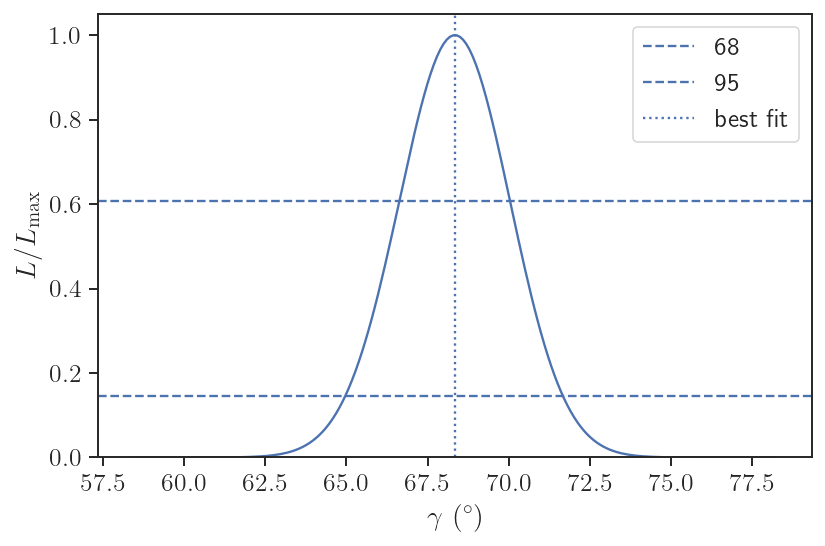

In [55]:
g0 = m.values["gamma"]
grid = np.linspace(g0 - 10, g0 + 10, 200)

grid, d2ll, prof = profile_scan_1d(m, "gamma", grid, fix=True)
plot_profile_peak(grid, d2ll, r"$\gamma\ (^\circ)$", best_val=g0)



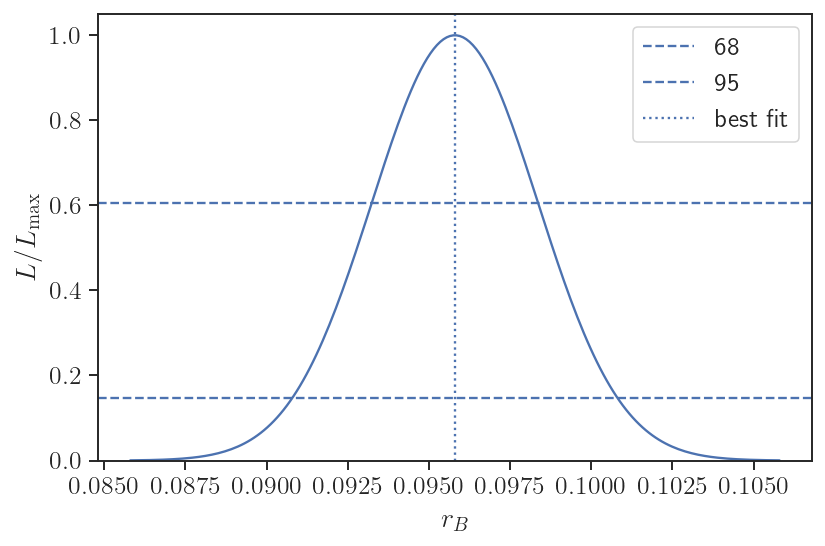

In [58]:
g0 = m.values["rB"]
grid = np.linspace(g0 - 0.01, g0 + 0.01, 200)

grid, d2ll, prof = profile_scan_1d(m, "rB", grid, fix=True)
plot_profile_peak(grid, d2ll, r"$r_B$", best_val=g0)


---
## 11. Profile Likelihood Scanning and Confidence Interval tools

Testing profile likelihood tools with simple example...
Best fit: x = 1.000, y = 2.000
x = 0.959 +1.132 -1.051
Saved test_profile_scan.png


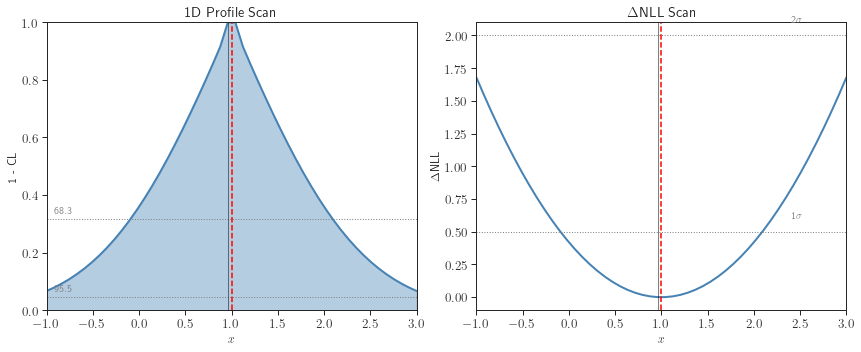

In [59]:
"""
Profile Likelihood Scanning and Confidence Interval Tools
==========================================================

This module provides functions to:
1. Perform 1D profile likelihood scans (like Figure 1 in the LHCb paper)
2. Perform 2D profile likelihood scans (contour plots)
3. Convert likelihood ratios to confidence levels
4. Plot 1-CL curves with proper 1σ/2σ bands

Works with iminuit Minuit objects after fitting.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from iminuit import Minuit
from typing import Tuple, Optional, Dict, List
import warnings


# ============================================================================
# THEORY: Converting Δ(NLL) to Confidence Levels
# ============================================================================
#
# For a profile likelihood ratio test statistic:
#   λ(θ) = L(θ, θ̂̂) / L(θ̂, θ̂̂)
#
# where θ̂̂ are the nuisance parameters that maximize L for fixed θ.
#
# Wilks' theorem states that -2 ln λ(θ) → χ²(n_dof) asymptotically,
# where n_dof = number of parameters of interest being tested.
#
# For 1D scans: Δχ² = 2 × ΔNLL follows χ²(1)
#   - 1σ (68.3% CL): Δχ² = 1.0
#   - 2σ (95.5% CL): Δχ² = 4.0
#   - 3σ (99.7% CL): Δχ² = 9.0
#
# For 2D scans: Δχ² follows χ²(2)
#   - 1σ (68.3% CL): Δχ² = 2.30
#   - 2σ (95.5% CL): Δχ² = 6.18
#   - 3σ (99.7% CL): Δχ² = 11.83
# ============================================================================


def delta_nll_to_confidence_level(delta_nll: np.ndarray, ndof: int = 1) -> np.ndarray:
    """
    Convert Δ(NLL) to confidence level (CL).
    
    Parameters
    ----------
    delta_nll : array-like
        Difference in negative log-likelihood from minimum: NLL - NLL_min
    ndof : int
        Number of degrees of freedom (1 for 1D scan, 2 for 2D scan)
    
    Returns
    -------
    cl : array
        Confidence level (between 0 and 1)
    
    Notes
    -----
    Uses Wilks' theorem: 2 × ΔNLL ~ χ²(ndof)
    CL = P(χ² < 2×ΔNLL) = CDF of χ² distribution
    """
    delta_chi2 = 2.0 * np.asarray(delta_nll)
    # CL is the probability that the true value lies within the region
    # where Δχ² is less than the observed value
    cl = stats.chi2.cdf(delta_chi2, df=ndof)
    return cl


def confidence_level_to_delta_nll(cl: float, ndof: int = 1) -> float:
    """
    Convert confidence level to Δ(NLL) threshold.
    
    Parameters
    ----------
    cl : float
        Confidence level (e.g., 0.683 for 1σ, 0.955 for 2σ)
    ndof : int
        Number of degrees of freedom
    
    Returns
    -------
    delta_nll : float
        The ΔNLL value corresponding to that confidence level
    """
    delta_chi2 = stats.chi2.ppf(cl, df=ndof)
    return delta_chi2 / 2.0


# Standard confidence levels
CL_1SIGMA = 0.6827  # 68.27%
CL_2SIGMA = 0.9545  # 95.45%
CL_3SIGMA = 0.9973  # 99.73%

# Corresponding Δχ² values for 1D
DELTA_CHI2_1D = {
    '1sigma': 1.0,
    '2sigma': 4.0,
    '3sigma': 9.0,
}

# Corresponding Δχ² values for 2D
DELTA_CHI2_2D = {
    '1sigma': 2.30,
    '2sigma': 6.18,
    '3sigma': 11.83,
}


# ============================================================================
# 1D Profile Likelihood Scan
# ============================================================================

def profile_likelihood_scan_1d(
    minuit: Minuit,
    param: str,
    bounds: Optional[Tuple[float, float]] = None,
    npoints: int = 100,
    subtract_min: bool = True
) -> Dict[str, np.ndarray]:
    """
    Perform a 1D profile likelihood scan using Minuit's mnprofile.
    
    Parameters
    ----------
    minuit : Minuit
        A Minuit object that has already been fitted (migrad called)
    param : str
        Name of the parameter to scan
    bounds : tuple, optional
        (min, max) range for the scan. If None, uses ±3σ from best fit
    npoints : int
        Number of points in the scan
    subtract_min : bool
        If True, subtract the minimum NLL value
    
    Returns
    -------
    dict with keys:
        'param_values': array of parameter values
        'nll': array of NLL values
        'delta_nll': array of ΔNLL (NLL - NLL_min)
        'cl': array of confidence levels
        'one_minus_cl': array of 1 - CL (for plotting like LHCb)
    """
    # Get best-fit value and error
    best_val = minuit.values[param]
    best_err = minuit.errors[param]
    
    # Set bounds if not provided
    if bounds is None:
        bounds = (best_val - 4*best_err, best_val + 4*best_err)
    
    # Use Minuit's built-in profile scan
    param_values, nll_values, success = minuit.mnprofile(
        param, 
        bound=bounds, 
        size=npoints,
        subtract_min=subtract_min
    )
    
    param_values = np.array(param_values)
    nll_values = np.array(nll_values)
    
    # If subtract_min is True, nll_values is already ΔNLL
    if subtract_min:
        delta_nll = nll_values
        nll_min = minuit.fval
    else:
        nll_min = nll_values.min()
        delta_nll = nll_values - nll_min
    
    # Convert to confidence level
    cl = delta_nll_to_confidence_level(delta_nll, ndof=1)
    
    return {
        'param_values': param_values,
        'nll': nll_values if not subtract_min else nll_values + nll_min,
        'delta_nll': delta_nll,
        'cl': cl,
        'one_minus_cl': 1.0 - cl,
        'best_fit': best_val,
        'best_err': best_err,
        'nll_min': nll_min
    }


def manual_profile_scan_1d(
    nll_func,
    minuit: Minuit,
    param: str,
    bounds: Tuple[float, float],
    npoints: int = 100,
    other_params: Optional[List[str]] = None
) -> Dict[str, np.ndarray]:
    """
    Manual 1D profile scan - useful when mnprofile has issues.
    
    For each fixed value of `param`, re-minimize over all other parameters.
    
    Parameters
    ----------
    nll_func : callable
        The negative log-likelihood function
    minuit : Minuit
        Fitted Minuit object (for initial values and limits)
    param : str
        Parameter to scan
    bounds : tuple
        (min, max) for the scan
    npoints : int
        Number of scan points
    other_params : list, optional
        List of other parameter names. If None, inferred from minuit.
    
    Returns
    -------
    dict : Same structure as profile_likelihood_scan_1d
    """
    if other_params is None:
        other_params = [p for p in minuit.parameters if p != param]
    
    param_values = np.linspace(bounds[0], bounds[1], npoints)
    nll_values = np.zeros(npoints)
    
    for i, pval in enumerate(param_values):
        # Create a wrapper that fixes the scan parameter
        def fixed_nll(**kwargs):
            kwargs[param] = pval
            return nll_func(**kwargs)
        
        # Set up minimizer for other parameters
        init_vals = {p: minuit.values[p] for p in other_params}
        m_temp = Minuit(fixed_nll, **init_vals)
        
        for p in other_params:
            m_temp.limits[p] = minuit.limits[p]
            m_temp.errors[p] = minuit.errors[p]
        
        m_temp.errordef = Minuit.LIKELIHOOD
        m_temp.migrad()
        
        nll_values[i] = m_temp.fval
    
    nll_min = nll_values.min()
    delta_nll = nll_values - nll_min
    cl = delta_nll_to_confidence_level(delta_nll, ndof=1)
    
    return {
        'param_values': param_values,
        'nll': nll_values,
        'delta_nll': delta_nll,
        'cl': cl,
        'one_minus_cl': 1.0 - cl,
        'best_fit': param_values[np.argmin(nll_values)],
        'nll_min': nll_min
    }


# ============================================================================
# 2D Profile Likelihood Scan (Contours)
# ============================================================================

def profile_likelihood_scan_2d(
    minuit: Minuit,
    param_x: str,
    param_y: str,
    bounds_x: Optional[Tuple[float, float]] = None,
    bounds_y: Optional[Tuple[float, float]] = None,
    npoints: int = 50
) -> Dict[str, np.ndarray]:
    """
    Perform a 2D profile likelihood scan.
    
    Parameters
    ----------
    minuit : Minuit
        Fitted Minuit object
    param_x, param_y : str
        Names of the two parameters to scan
    bounds_x, bounds_y : tuple, optional
        Scan ranges. If None, uses ±3σ from best fit
    npoints : int
        Number of points along each axis
    
    Returns
    -------
    dict with keys:
        'x_values', 'y_values': 1D arrays of scan points
        'X', 'Y': 2D meshgrid arrays
        'delta_nll': 2D array of ΔNLL values
        'delta_chi2': 2D array of Δχ² values
        'cl': 2D array of confidence levels
    """
    # Get best-fit values and errors
    best_x, err_x = minuit.values[param_x], minuit.errors[param_x]
    best_y, err_y = minuit.values[param_y], minuit.errors[param_y]
    
    if bounds_x is None:
        bounds_x = (best_x - 4*err_x, best_x + 4*err_x)
    if bounds_y is None:
        bounds_y = (best_y - 4*err_y, best_y + 4*err_y)
    
    # Use Minuit's contour method for accurate profiling
    # This returns the contour points, but we need the full grid
    # So we'll do a manual grid scan with profiling
    
    x_values = np.linspace(bounds_x[0], bounds_x[1], npoints)
    y_values = np.linspace(bounds_y[0], bounds_y[1], npoints)
    X, Y = np.meshgrid(x_values, y_values)
    
    delta_nll = np.zeros_like(X)
    nll_min = minuit.fval
    
    # Get the NLL function and other parameters
    other_params = [p for p in minuit.parameters if p not in (param_x, param_y)]
    
    print(f"Performing 2D scan over {param_x} and {param_y}...")
    for i in range(npoints):
        for j in range(npoints):
            # Fix param_x and param_y, profile over others
            minuit.fixed[param_x] = True
            minuit.fixed[param_y] = True
            minuit.values[param_x] = x_values[j]
            minuit.values[param_y] = y_values[i]
            
            # Re-minimize over free parameters
            if other_params:
                minuit.migrad()
            
            delta_nll[i, j] = minuit.fval - nll_min
    
    # Unfix parameters
    minuit.fixed[param_x] = False
    minuit.fixed[param_y] = False
    
    # Restore best-fit values
    minuit.values[param_x] = best_x
    minuit.values[param_y] = best_y
    minuit.migrad()
    
    delta_chi2 = 2.0 * delta_nll
    cl = delta_nll_to_confidence_level(delta_nll, ndof=2)
    
    return {
        'x_values': x_values,
        'y_values': y_values,
        'X': X,
        'Y': Y,
        'delta_nll': delta_nll,
        'delta_chi2': delta_chi2,
        'cl': cl,
        'best_x': best_x,
        'best_y': best_y
    }


def get_contour_from_minuit(
    minuit: Minuit,
    param_x: str,
    param_y: str,
    cl: float = CL_1SIGMA,
    npoints: int = 100
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get contour points at a specific confidence level using Minuit's mncontour.
    
    This is more accurate than interpolating a grid scan.
    """
    # Convert CL to number of sigma for Minuit
    # Minuit's mncontour uses sigma as input
    nsigma = np.sqrt(stats.chi2.ppf(cl, df=2))
    
    x_contour, y_contour = minuit.mncontour(param_x, param_y, size=npoints)
    return np.array(x_contour), np.array(y_contour)


# ============================================================================
# Plotting Functions
# ============================================================================

def plot_1d_profile_scan(
    scan_result: Dict[str, np.ndarray],
    param_name: str,
    param_label: Optional[str] = None,
    true_value: Optional[float] = None,
    ax: Optional[plt.Axes] = None,
    plot_style: str = 'lhcb',  # 'lhcb' for 1-CL, 'delta_nll' for ΔNLL
    color: str = 'steelblue',
    fill: bool = True,
    show_intervals: bool = True
) -> plt.Axes:
    """
    Plot 1D profile likelihood scan results.
    
    Parameters
    ----------
    scan_result : dict
        Output from profile_likelihood_scan_1d
    param_name : str
        Parameter name (for title)
    param_label : str, optional
        LaTeX label for x-axis
    true_value : float, optional
        If provided, draw a vertical line at the true value
    ax : Axes, optional
        Matplotlib axes. If None, creates new figure
    plot_style : str
        'lhcb' for 1-CL plot (like Figure 1), 'delta_nll' for ΔNLL plot
    color : str
        Fill/line color
    fill : bool
        Whether to fill under the curve
    show_intervals : bool
        Whether to show 1σ/2σ horizontal lines
    
    Returns
    -------
    ax : Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    x = scan_result['param_values']
    
    if plot_style == 'lhcb':
        y = scan_result['one_minus_cl']
        ylabel = '1 - CL'
        
        if fill:
            ax.fill_between(x, 0, y, alpha=0.4, color=color)
        ax.plot(x, y, color=color, lw=2)
        
        if show_intervals:
            # 1σ and 2σ lines
            ax.axhline(1 - CL_1SIGMA, color='gray', ls=':', lw=1, label='68.3%')
            ax.axhline(1 - CL_2SIGMA, color='gray', ls=':', lw=1, label='95.5%')
            ax.text(x.min() + 0.02*(x.max()-x.min()), 1 - CL_1SIGMA + 0.02, 
                    '68.3%', fontsize=10, color='gray')
            ax.text(x.min() + 0.02*(x.max()-x.min()), 1 - CL_2SIGMA + 0.02, 
                    '95.5%', fontsize=10, color='gray')
        
        ax.set_ylim(0, 1)
        
    else:  # delta_nll
        y = scan_result['delta_nll']
        ylabel = r'$\Delta$NLL'
        
        ax.plot(x, y, color=color, lw=2)
        
        if show_intervals:
            # 1σ and 2σ lines (ΔNLL = 0.5 and 2.0)
            ax.axhline(0.5, color='gray', ls=':', lw=1)
            ax.axhline(2.0, color='gray', ls=':', lw=1)
            ax.text(x.max() - 0.15*(x.max()-x.min()), 0.5 + 0.1, 
                    r'1$\sigma$', fontsize=10, color='gray')
            ax.text(x.max() - 0.15*(x.max()-x.min()), 2.0 + 0.1, 
                    r'2$\sigma$', fontsize=10, color='gray')
    
    if true_value is not None:
        ax.axvline(true_value, color='red', ls='--', lw=1.5, label='True value')
    
    # Mark best fit
    best_idx = np.argmin(scan_result['delta_nll'])
    ax.axvline(x[best_idx], color='black', ls='-', lw=1, alpha=0.5)
    
    ax.set_xlabel(param_label or param_name, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlim(x.min(), x.max())
    
    return ax


def plot_1d_scans_grid(
    minuit: Minuit,
    params: List[str],
    param_labels: Optional[Dict[str, str]] = None,
    true_values: Optional[Dict[str, float]] = None,
    bounds: Optional[Dict[str, Tuple[float, float]]] = None,
    npoints: int = 100,
    ncols: int = 2,
    figsize: Optional[Tuple[float, float]] = None,
    plot_style: str = 'lhcb'
) -> plt.Figure:
    """
    Create a grid of 1D profile likelihood scans for multiple parameters.
    
    Similar to Figure 1 in the LHCb paper.
    """
    nparams = len(params)
    nrows = (nparams + ncols - 1) // ncols
    
    if figsize is None:
        figsize = (5 * ncols, 4 * nrows)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.atleast_2d(axes)
    
    if param_labels is None:
        param_labels = {}
    if true_values is None:
        true_values = {}
    if bounds is None:
        bounds = {}
    
    for i, param in enumerate(params):
        row, col = i // ncols, i % ncols
        ax = axes[row, col]
        
        # Perform scan
        scan = profile_likelihood_scan_1d(
            minuit, param,
            bounds=bounds.get(param),
            npoints=npoints
        )
        
        # Plot
        plot_1d_profile_scan(
            scan, param,
            param_label=param_labels.get(param, param),
            true_value=true_values.get(param),
            ax=ax,
            plot_style=plot_style
        )
        
        # Add experiment label (like LHCb)
        ax.text(0.95, 0.95, 'Your Experiment', transform=ax.transAxes,
                ha='right', va='top', fontsize=10)
    
    # Hide empty subplots
    for i in range(nparams, nrows * ncols):
        row, col = i // ncols, i % ncols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    return fig


def plot_2d_contours(
    scan_result: Dict[str, np.ndarray],
    param_x_label: Optional[str] = None,
    param_y_label: Optional[str] = None,
    true_values: Optional[Tuple[float, float]] = None,
    ax: Optional[plt.Axes] = None,
    levels: List[str] = ['1sigma', '2sigma'],
    colors: Optional[List[str]] = None,
    filled: bool = True
) -> plt.Axes:
    """
    Plot 2D profile likelihood contours.
    
    Parameters
    ----------
    scan_result : dict
        Output from profile_likelihood_scan_2d
    param_x_label, param_y_label : str
        Axis labels
    true_values : tuple, optional
        (true_x, true_y) to mark with a star
    ax : Axes, optional
    levels : list
        Which contours to draw ('1sigma', '2sigma', '3sigma')
    colors : list, optional
        Colors for each contour level
    filled : bool
        Whether to use filled contours
    
    Returns
    -------
    ax : Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    
    if colors is None:
        colors = ['steelblue', 'lightsteelblue', 'lavender']
    
    X, Y = scan_result['X'], scan_result['Y']
    delta_chi2 = scan_result['delta_chi2']
    
    # Get contour levels
    contour_levels = [DELTA_CHI2_2D[l] for l in levels]
    
    if filled:
        # Sort levels in decreasing order for proper layering
        sorted_idx = np.argsort(contour_levels)[::-1]
        sorted_levels = [contour_levels[i] for i in sorted_idx]
        sorted_colors = [colors[i] for i in sorted_idx]
        
        for level, color in zip(sorted_levels, sorted_colors):
            ax.contourf(X, Y, delta_chi2, levels=[0, level], 
                       colors=[color], alpha=0.7)
    
    # Draw contour lines
    cs = ax.contour(X, Y, delta_chi2, levels=contour_levels,
                    colors='darkblue', linewidths=1.5)
    
    # Label contours
    fmt = {DELTA_CHI2_2D['1sigma']: r'1$\sigma$',
           DELTA_CHI2_2D['2sigma']: r'2$\sigma$',
           DELTA_CHI2_2D['3sigma']: r'3$\sigma$'}
    ax.clabel(cs, inline=True, fontsize=10, fmt=fmt)
    
    # Mark best fit
    ax.plot(scan_result['best_x'], scan_result['best_y'], 
            'k+', ms=10, mew=2, label='Best fit')
    
    # Mark true value
    if true_values is not None:
        ax.plot(true_values[0], true_values[1], 
                'r*', ms=15, label='True value')
    
    ax.set_xlabel(param_x_label or 'x', fontsize=12)
    ax.set_ylabel(param_y_label or 'y', fontsize=12)
    ax.legend(loc='upper right')
    
    return ax


# ============================================================================
# Confidence Interval Extraction
# ============================================================================

def extract_confidence_interval(
    scan_result: Dict[str, np.ndarray],
    cl: float = CL_1SIGMA
) -> Tuple[float, float, float]:
    """
    Extract confidence interval from 1D scan.
    
    Returns
    -------
    (best_fit, lower_error, upper_error)
    
    The interval is [best_fit - lower_error, best_fit + upper_error]
    """
    x = scan_result['param_values']
    delta_nll = scan_result['delta_nll']
    
    # Find best fit
    best_idx = np.argmin(delta_nll)
    best_fit = x[best_idx]
    
    # Threshold ΔNLL for this CL (1D)
    threshold = confidence_level_to_delta_nll(cl, ndof=1)
    
    # Find where ΔNLL crosses threshold
    # Lower bound: search below best fit
    lower_region = x[:best_idx+1]
    lower_dnll = delta_nll[:best_idx+1]
    
    if np.any(lower_dnll > threshold):
        # Interpolate to find crossing
        idx = np.where(lower_dnll > threshold)[0][-1]
        if idx < len(lower_region) - 1:
            # Linear interpolation
            x1, x2 = lower_region[idx], lower_region[idx+1]
            y1, y2 = lower_dnll[idx], lower_dnll[idx+1]
            lower_bound = x1 + (threshold - y1) * (x2 - x1) / (y2 - y1)
        else:
            lower_bound = lower_region[idx]
    else:
        lower_bound = lower_region[0]
    
    # Upper bound: search above best fit
    upper_region = x[best_idx:]
    upper_dnll = delta_nll[best_idx:]
    
    if np.any(upper_dnll > threshold):
        idx = np.where(upper_dnll > threshold)[0][0]
        if idx > 0:
            x1, x2 = upper_region[idx-1], upper_region[idx]
            y1, y2 = upper_dnll[idx-1], upper_dnll[idx]
            upper_bound = x1 + (threshold - y1) * (x2 - x1) / (y2 - y1)
        else:
            upper_bound = upper_region[idx]
    else:
        upper_bound = upper_region[-1]
    
    lower_error = best_fit - lower_bound
    upper_error = upper_bound - best_fit
    
    return best_fit, lower_error, upper_error


def print_results_with_asymmetric_errors(
    minuit: Minuit,
    params: Optional[List[str]] = None,
    true_values: Optional[Dict[str, float]] = None,
    npoints: int = 100
):
    """
    Print fit results with asymmetric errors from profile likelihood.
    """
    if params is None:
        params = list(minuit.parameters)
    
    print("=" * 60)
    print("Profile Likelihood Results")
    print("=" * 60)
    
    for param in params:
        scan = profile_likelihood_scan_1d(minuit, param, npoints=npoints)
        best, lo, hi = extract_confidence_interval(scan, CL_1SIGMA)
        
        result_str = f"{param} = {best:.4f} + {hi:.4f} - {lo:.4f}"
        
        if true_values and param in true_values:
            result_str += f"  (true: {true_values[param]:.4f})"
        
        print(result_str)
    
    print("=" * 60)


# ============================================================================
# Example usage function
# ============================================================================

def example_with_your_fitter(minuit_result, true_rB, true_deltaB, true_gamma):
    """
    Example of how to use these tools with your fitting routine.
    
    Parameters
    ----------
    minuit_result : Minuit
        The Minuit object returned by your fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC
    true_rB, true_deltaB, true_gamma : float
        True values for comparison
    """
    
    # 1. Create 1D profile scans (like LHCb Figure 1)
    fig = plot_1d_scans_grid(
        minuit_result,
        params=['rB', 'delta', 'gamma'],
        param_labels={
            'rB': r'$r_B$',
            'delta': r'$\delta_B$ [°]',
            'gamma': r'$\gamma$ [°]'
        },
        true_values={
            'rB': true_rB,
            'delta': true_deltaB,
            'gamma': true_gamma
        },
        plot_style='lhcb'  # 1-CL style like Figure 1
    )
    fig.savefig('profile_scans_1d.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Create 2D contour (delta vs gamma)
    scan_2d = profile_likelihood_scan_2d(
        minuit_result,
        'delta', 'gamma',
        npoints=30  # Use fewer points for speed; increase for publication
    )
    
    fig2, ax2 = plt.subplots(figsize=(7, 6))
    plot_2d_contours(
        scan_2d,
        param_x_label=r'$\delta_B$ [°]',
        param_y_label=r'$\gamma$ [°]',
        true_values=(true_deltaB, true_gamma),
        ax=ax2
    )
    fig2.savefig('profile_contour_2d.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 3. Print results with asymmetric errors
    print_results_with_asymmetric_errors(
        minuit_result,
        true_values={'rB': true_rB, 'delta': true_deltaB, 'gamma': true_gamma}
    )


if __name__ == "__main__":
    # Quick test with a simple Gaussian likelihood
    print("Testing profile likelihood tools with simple example...")
    
    # Simple 2D Gaussian NLL (correlated)
    def test_nll(x, y):
        # Correlated Gaussian with true values at (1, 2)
        dx, dy = x - 1.0, y - 2.0
        return 0.5 * (dx**2 + dy**2 + 0.8*dx*dy)
    
    m = Minuit(test_nll, x=0.5, y=1.5)
    m.errordef = Minuit.LIKELIHOOD
    m.migrad()
    m.hesse()
    
    print(f"Best fit: x = {m.values['x']:.3f}, y = {m.values['y']:.3f}")
    
    # 1D scan
    scan_x = profile_likelihood_scan_1d(m, 'x', bounds=(-1, 3), npoints=50)
    best, lo, hi = extract_confidence_interval(scan_x)
    print(f"x = {best:.3f} +{hi:.3f} -{lo:.3f}")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    plot_1d_profile_scan(scan_x, 'x', r'$x$', true_value=1.0, 
                         ax=axes[0], plot_style='lhcb')
    axes[0].set_title('1D Profile Scan')
    
    plot_1d_profile_scan(scan_x, 'x', r'$x$', true_value=1.0, 
                         ax=axes[1], plot_style='delta_nll')
    axes[1].set_title(r'$\Delta$NLL Scan')
    
    plt.tight_layout()
    plt.savefig('test_profile_scan.png', dpi=100)
    print("Saved test_profile_scan.png")

DEMONSTRATION: Profile Likelihood Analysis for γ Measurement

True values: rB = 0.1, δB = 130.0°, γ = 70.0°


PROFILE LIKELIHOOD ANALYSIS

Performing 1D profile scans...

--------------------------------------------------
FIT RESULTS (Profile Likelihood)
--------------------------------------------------
rB     =   0.0959 +0.0024 -0.0027
         (true: 0.1000, pull: -1.59σ)
delta  = 129.8182 +1.7317 -1.6336°
         (true: 130.0000°, pull: -0.11σ)
gamma  =  68.2906 +1.7492 -1.6650°
         (true: 70.0000°, pull: -1.00σ)

2σ (95.5% CL) intervals:
  rB: [0.0907, 0.1009]
  delta: [126.4976, 133.2283]°
  gamma: [64.8982, 71.7281]°

Generating 1-CL plots...
  Saved: demo_gamma_fit_1d_scans.png/pdf
  Saved: demo_gamma_fit_nll_scans.png

Performing 2D profile scan (gamma vs delta)...
  (This may take a few minutes...)
Performing 2D scan over gamma and delta...
  Saved: demo_gamma_fit_2d_contour.png/pdf

ANALYSIS COMPLETE


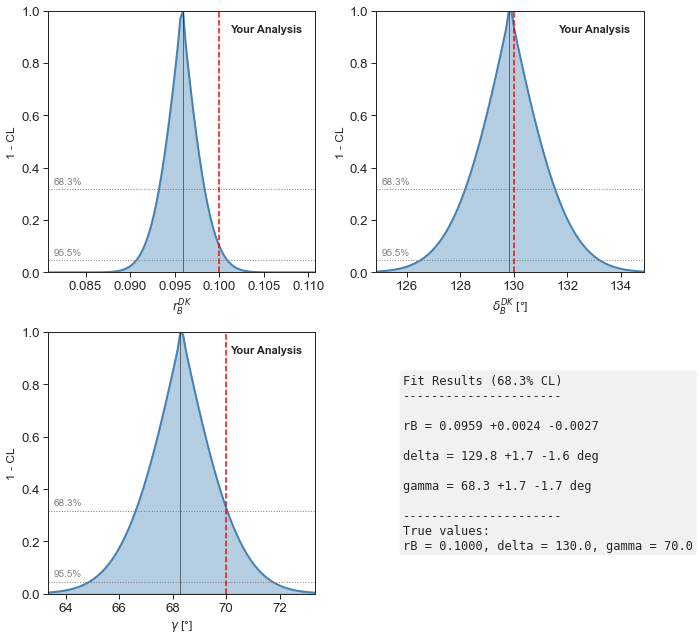

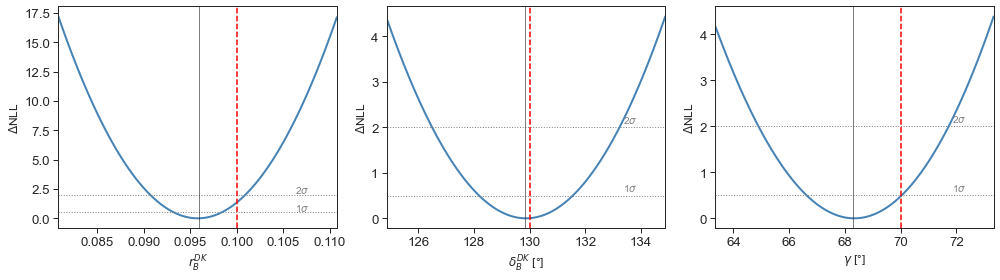

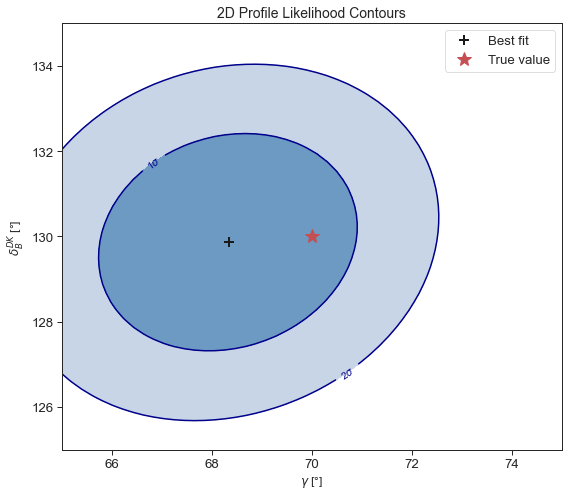

In [73]:
"""
Example: Using Profile Likelihood Tools with Your B→DK Fitter
==============================================================

This script shows how to add 1-CL scans and confidence interval plots
to your existing fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC routine.
"""

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

# Disable LaTeX rendering to avoid Unicode issues
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'


def analyze_fit_results(
    minuit_result: Minuit,
    true_rB: float,
    true_deltaB: float, 
    true_gamma: float,
    output_prefix: str = "gamma_fit"
):
    """
    Complete analysis of fit results with profile likelihood scans.
    
    Call this after running your fit:
    
        m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(...)
        analyze_fit_results(m, true_rB, true_deltaB, true_gamma)
    
    Parameters
    ----------
    minuit_result : Minuit
        The fitted Minuit object from your routine
    true_rB, true_deltaB, true_gamma : float
        True/injected values for comparison
    output_prefix : str
        Prefix for output file names
    """
    
    print("\n" + "="*70)
    print("PROFILE LIKELIHOOD ANALYSIS")
    print("="*70 + "\n")
    
    # -------------------------------------------------------------------------
    # 1. Individual 1D Profile Scans
    # -------------------------------------------------------------------------
    print("Performing 1D profile scans...")
    
    # Scan ranges (adjust based on your typical uncertainties)
    scan_bounds = {
        'rB': (max(0, minuit_result.values['rB'] - 0.015), 
               min(0.5, minuit_result.values['rB'] + 0.015)),
        'delta': (minuit_result.values['delta'] - 5, 
                  minuit_result.values['delta'] + 5),
        'gamma': (minuit_result.values['gamma'] - 5, 
                  minuit_result.values['gamma'] + 5)
    }
    
    # Perform scans
    scans = {}
    for param in ['rB', 'delta', 'gamma']:
        scans[param] = profile_likelihood_scan_1d(
            minuit_result, 
            param,
            bounds=scan_bounds[param],
            npoints=100
        )
    
    # -------------------------------------------------------------------------
    # 2. Extract confidence intervals with asymmetric errors
    # -------------------------------------------------------------------------
    print("\n" + "-"*50)
    print("FIT RESULTS (Profile Likelihood)")
    print("-"*50)
    
    results = {}
    for param, true_val in [('rB', true_rB), ('delta', true_deltaB), ('gamma', true_gamma)]:
        best, lo, hi = extract_confidence_interval(scans[param], CL_1SIGMA)
        results[param] = {'best': best, 'lo': lo, 'hi': hi}
        
        unit = '°' if param in ['delta', 'gamma'] else ''
        print(f"{param:6s} = {best:8.4f} +{hi:.4f} -{lo:.4f}{unit}")
        print(f"         (true: {true_val:.4f}{unit}, "
              f"pull: {(best-true_val)/((lo+hi)/2):+.2f}σ)")
    
    # Also get 2σ intervals
    print("\n2σ (95.5% CL) intervals:")
    for param in ['rB', 'delta', 'gamma']:
        best, lo, hi = extract_confidence_interval(scans[param], CL_2SIGMA)
        unit = '°' if param in ['delta', 'gamma'] else ''
        print(f"  {param}: [{best-lo:.4f}, {best+hi:.4f}]{unit}")
    
    # -------------------------------------------------------------------------
    # 3. Create LHCb-style 1-CL plots (Figure 1 style)
    # -------------------------------------------------------------------------
    print("\nGenerating 1-CL plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 9))
    
    # rB scan
    plot_1d_profile_scan(
        scans['rB'], 'rB',
        param_label=r'$r_B^{DK}$',
        true_value=true_rB,
        ax=axes[0, 0],
        plot_style='lhcb'
    )
    axes[0, 0].text(0.95, 0.95, 'Your Analysis', transform=axes[0, 0].transAxes,
                    ha='right', va='top', fontsize=11, fontweight='bold')
    
    # delta scan
    plot_1d_profile_scan(
        scans['delta'], 'delta',
        param_label=r'$\delta_B^{DK}$ [°]',
        true_value=true_deltaB,
        ax=axes[0, 1],
        plot_style='lhcb'
    )
    axes[0, 1].text(0.95, 0.95, 'Your Analysis', transform=axes[0, 1].transAxes,
                    ha='right', va='top', fontsize=11, fontweight='bold')
    
    # gamma scan
    plot_1d_profile_scan(
        scans['gamma'], 'gamma',
        param_label=r'$\gamma$ [°]',
        true_value=true_gamma,
        ax=axes[1, 0],
        plot_style='lhcb'
    )
    axes[1, 0].text(0.95, 0.95, 'Your Analysis', transform=axes[1, 0].transAxes,
                    ha='right', va='top', fontsize=11, fontweight='bold')
    
    # Summary text in fourth panel
    axes[1, 1].axis('off')
    summary_text = (
        f"Fit Results (68.3% CL)\n"
        f"----------------------\n\n"
        f"rB = {results['rB']['best']:.4f}"
        f" +{results['rB']['hi']:.4f} -{results['rB']['lo']:.4f}\n\n"
        f"delta = {results['delta']['best']:.1f}"
        f" +{results['delta']['hi']:.1f} -{results['delta']['lo']:.1f} deg\n\n"
        f"gamma = {results['gamma']['best']:.1f}"
        f" +{results['gamma']['hi']:.1f} -{results['gamma']['lo']:.1f} deg\n\n"
        f"----------------------\n"
        f"True values:\n"
        f"rB = {true_rB:.4f}, delta = {true_deltaB:.1f}, gamma = {true_gamma:.1f}"
    )
    axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                    fontsize=12, verticalalignment='center',
                    family='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig(f'{output_prefix}_1d_scans.png', dpi=150, bbox_inches='tight')
    plt.savefig(f'{output_prefix}_1d_scans.pdf', bbox_inches='tight')
    print(f"  Saved: {output_prefix}_1d_scans.png/pdf")
    
    # -------------------------------------------------------------------------
    # 4. Alternative: ΔNLL plots (parabola-style)
    # -------------------------------------------------------------------------
    fig2, axes2 = plt.subplots(1, 3, figsize=(14, 4))
    
    for ax, (param, label, true_val) in zip(
        axes2, 
        [('rB', r'$r_B^{DK}$', true_rB),
         ('delta', r'$\delta_B^{DK}$ [°]', true_deltaB),
         ('gamma', r'$\gamma$ [°]', true_gamma)]
    ):
        plot_1d_profile_scan(
            scans[param], param,
            param_label=label,
            true_value=true_val,
            ax=ax,
            plot_style='delta_nll'
        )
    
    plt.tight_layout()
    plt.savefig(f'{output_prefix}_nll_scans.png', dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_prefix}_nll_scans.png")
    
    # -------------------------------------------------------------------------
    # 5. 2D Contour: gamma vs delta (like LHCb Figure 4)
    # -------------------------------------------------------------------------
    print("\nPerforming 2D profile scan (gamma vs delta)...")
    print("  (This may take a few minutes...)")
    
    scan_2d = profile_likelihood_scan_2d(
        minuit_result,
        'gamma', 'delta',
        bounds_x=(true_gamma - 5, true_gamma + 5),
        bounds_y=(true_deltaB - 5, true_deltaB + 5),
        npoints = 50  # Increase to 40-50 for publication quality
    )
    
    fig3, ax3 = plt.subplots(figsize=(8, 7))
    plot_2d_contours(
        scan_2d,
        param_x_label=r'$\gamma$ [°]',
        param_y_label=r'$\delta_B^{DK}$ [°]',
        true_values=(true_gamma, true_deltaB),
        ax=ax3,
        levels=['1sigma', '2sigma']
    )
    ax3.set_title('2D Profile Likelihood Contours', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f'{output_prefix}_2d_contour.png', dpi=150, bbox_inches='tight')
    plt.savefig(f'{output_prefix}_2d_contour.pdf', bbox_inches='tight')
    print(f"  Saved: {output_prefix}_2d_contour.png/pdf")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    return scans, scan_2d, results


# =============================================================================
# Quick integration with your existing code
# =============================================================================

def extended_fit_with_plots(m, 
    true_rB, true_deltaB, true_gamma,
    make_plots=True, output_prefix="gamma_fit"
):
    """
    Wrapper that runs your fit and automatically generates profile likelihood plots.
    
    Just replace your call to fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC
    with this function.
    """
    
    if make_plots:
        analyze_fit_results(m, true_rB, true_deltaB, true_gamma, output_prefix)
    return m


# =============================================================================
# Run demonstration
# =============================================================================

if __name__ == "__main__":
    # True values (as in your analysis)
    TRUE_RB = 0.1
    TRUE_DELTA = 130.0  # degrees
    TRUE_GAMMA = 70.0   # degrees
    
    print("="*70)
    print("DEMONSTRATION: Profile Likelihood Analysis for γ Measurement")
    print("="*70)
    print(f"\nTrue values: rB = {TRUE_RB}, δB = {TRUE_DELTA}°, γ = {TRUE_GAMMA}°\n")
    
    # Run the extended fit
    m = extended_fit_with_plots(m, 
        true_rB=TRUE_RB, true_deltaB=TRUE_DELTA, true_gamma=TRUE_GAMMA,
        make_plots=True,
        output_prefix="demo_gamma_fit"
    )
    
    plt.show()

Accounting for uncertainty in D decay through Bootstrapping

In [83]:
# Function to load ensemble of flow models and compute per-event pF statistics
def load_ensemble_flows(ensemble_dir, num_flows=16, hidden_features=128, num_bins=16, device='cpu'):
    """
    Load all flow models from ensemble directory.
    
    Parameters
    ----------
    ensemble_dir : str
        Directory containing trial_seedN.pth files
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    device : str
        Device for computation
    
    Returns
    -------
    flow_models : list
        List of loaded flow models
    """
    import glob
    
    # Find all model files (exclude *_best.pth)
    model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
    model_files = [f for f in model_files if not f.endswith('_best.pth')]
    
    print(f"Loading {len(model_files)} models from {ensemble_dir}...")
    
    flow_models = []
    for model_path in model_files:
        # Create flow architecture
        flow = conjure_flow(num_flows=num_flows, hidden_features=hidden_features, num_bins=num_bins)
        
        # Load weights
        flow.load_state_dict(torch.load(model_path, map_location=device))
        flow.eval()
        flow.to(device)
        
        flow_models.append(flow)
    
    print(f"Successfully loaded {len(flow_models)} models")
    return flow_models


In [98]:
def compute_interference_terms_ensemble(
    points_sdp, flow_ensemble, sdp_obj, idx=(1,2,3), device=None
):
    """
    Compute pF and pFsw statistics from ensemble of flow models.
    
    This function computes only the pF and pFsw terms (which depend on the flow
    ensemble). The C, S, and J terms are computed separately using single models
    since they don't have model uncertainty (J is just coordinate transformation,
    C and S use separate flow_even/flow_odd models).
    
    Parameters
    ----------
    points_sdp : ndarray, shape (N, 2)
        Points in Square Dalitz Plot coordinates
    flow_ensemble : list
        List of flow models for flavor amplitude
    sdp_obj : SDP object
        Square Dalitz Plot object for coordinate transformations
    idx : tuple
        Particle indices (1,2,3)
    device : str
        Device for computation
    
    Returns
    -------
    result : dict
        Dictionary containing:
        - pF_mean, pF_std : mean and std of pF across ensemble
        - pFsw_mean, pFsw_std : mean and std of pFsw across ensemble
    """
    n_models = len(flow_ensemble)
    n_points = len(points_sdp)
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Store results from each model
    pF_ensemble = np.zeros((n_models, n_points))
    pFsw_ensemble = np.zeros((n_models, n_points))
    
    # Compute pF and pFsw for each model
    for i, flow_flavor in enumerate(flow_ensemble):
        # pF: mag^2 from original coordinates
        mag_AD, _ = mag_AD_from_flow(points_sdp, flow_flavor, sdp_obj, idx=idx, device=device)
        pF_ensemble[i] = _finite_pos(mag_AD) ** 2
        
        # pFsw: mag^2 from swapped coordinates (s12 <-> s13)
        # First get (s12, s13) in DP
        dp = sdp_to_dp(points_sdp, sdp_obj, idx=idx)
        s12, s13 = dp[:, 0], dp[:, 1]
        
        # Swap to get coordinates for the other pair
        U13 = swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2))
        mag_AD_sw, _ = mag_AD_from_flow(U13, flow_flavor, sdp_obj, idx=(1,3,2), device=device)
        pFsw_ensemble[i] = _finite_pos(mag_AD_sw) ** 2
    
    # Compute statistics across ensemble
    pF_mean = pF_ensemble.mean(axis=0)
    pF_std = pF_ensemble.std(axis=0, ddof=1)  # Sample std
    
    pFsw_mean = pFsw_ensemble.mean(axis=0)
    pFsw_std = pFsw_ensemble.std(axis=0, ddof=1)
    
    return {
        'pF_mean': pF_mean,
        'pF_std': pF_std,
        'pFsw_mean': pFsw_mean,
        'pFsw_std': pFsw_std
    }


In [132]:
def fit_with_flow_ensemble(
    dataM_sdp, dataP_sdp, mcM_sdp, mcP_sdp,
    flow_ensemble_flavor, flow_even, flow_odd, dkpp_model,
    true_rB, true_deltaB, true_gamma,
    sdp_obj, idx=(1,2,3),
    initial_scale=0.2, delta_offset=30, gamma_offset=30,
    device=None, eps=1e-14, Gamma_minus=1, Gamma_plus=1, k=1
):
    """
    Fit r_B, delta, gamma with flow ensemble uncertainty via single nuisance parameter.
    
    Follows the structure of fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC but
    uses ensemble statistics for pF and pFsw with nuisance parameter alpha_pF.
    C, S, and J are computed from single models (no ensemble uncertainty).
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"\nFitting with ensemble uncertainty...")
    print(f"N(B-) = {len(dataM_sdp)}, N(B+) = {len(dataP_sdp)}")
    print(f"Ensemble size: {len(flow_ensemble_flavor)} models")
    
    # ============================================================
    # Compute pF and pFsw ensemble statistics
    # ============================================================
    print("Computing pF/pFsw ensemble statistics for data B-...")
    ens_M = compute_interference_terms_ensemble(
        dataM_sdp, flow_ensemble_flavor, sdp_obj, idx=idx, device=device
    )
    
    print("Computing pF/pFsw ensemble statistics for data B+...")
    ens_P = compute_interference_terms_ensemble(
        dataP_sdp, flow_ensemble_flavor, sdp_obj, idx=idx, device=device
    )
    
    print("Computing pF/pFsw ensemble statistics for MC B-...")
    ens_mcM = compute_interference_terms_ensemble(
        mcM_sdp, flow_ensemble_flavor, sdp_obj, idx=idx, device=device
    )
    
    print("Computing pF/pFsw ensemble statistics for MC B+...")
    ens_mcP = compute_interference_terms_ensemble(
        mcP_sdp, flow_ensemble_flavor, sdp_obj, idx=idx, device=device
    )
    
    print(f"\nEnsemble statistics computed.")
    print(f"  Mean pF std: {ens_M['pF_std'].mean():.6f}")
    print(f"  Mean pFsw std: {ens_M['pFsw_std'].mean():.6f}")
    
    # ============================================================
    # Compute C, S, and J terms using single flow models
    # ============================================================
    print("\nComputing C, S, and J with single models...")
    
    # Use first model from ensemble
    flow_flavor_single = flow_ensemble_flavor[0]
    
    tM = compute_interference_terms(
        dataM_sdp, flow_flavor_single, flow_even, flow_odd, dkpp_model,
        sdp_obj, Gamma_minus=Gamma_minus, Gamma_plus=Gamma_plus, idx=idx, device=device
    )
    
    tP = compute_interference_terms(
        dataP_sdp, flow_flavor_single, flow_even, flow_odd, dkpp_model,
        sdp_obj, Gamma_minus=Gamma_minus, Gamma_plus=Gamma_plus, idx=idx, device=device
    )
    
    mM = compute_interference_terms(
        mcM_sdp, flow_flavor_single, flow_even, flow_odd, dkpp_model,
        sdp_obj, Gamma_minus=Gamma_minus, Gamma_plus=Gamma_plus, idx=idx, device=device
    )
    
    mP = compute_interference_terms(
        mcP_sdp, flow_flavor_single, flow_even, flow_odd, dkpp_model,
        sdp_obj, Gamma_minus=Gamma_minus, Gamma_plus=Gamma_plus, idx=idx, device=device
    )
    
    # ============================================================
    # HARD CUT: keep only physical points |C| <= abJ
    # ============================================================
    maskM = (np.abs(tM['C']) <= tM['abJ'])
    maskP = (np.abs(tP['C']) <= tP['abJ'])
    maskMC_M = (np.abs(mM['C']) <= mM['abJ'])
    maskMC_P = (np.abs(mP['C']) <= mP['abJ'])
    
    print(f"\nData cuts: B- kept {maskM.sum()}/{len(maskM)}, B+ kept {maskP.sum()}/{len(maskP)}")
    print(f"MC cuts: B- kept {maskMC_M.sum()}/{len(maskMC_M)}, B+ kept {maskMC_P.sum()}/{len(maskMC_P)}")
    
    # Apply cuts to interference terms (C, S, J from single model)
    for key in tM:
        tM[key] = tM[key][maskM]
    for key in tP:
        tP[key] = tP[key][maskP]
    for key in mM:
        mM[key] = mM[key][maskMC_M]
    for key in mP:
        mP[key] = mP[key][maskMC_P]
    
    # Apply cuts to ensemble statistics (pF and pFsw only)
    pF_mean_M = ens_M['pF_mean'][maskM]
    pF_std_M = ens_M['pF_std'][maskM]
    pFsw_mean_M = ens_M['pFsw_mean'][maskM]
    pFsw_std_M = ens_M['pFsw_std'][maskM]
    
    pF_mean_P = ens_P['pF_mean'][maskP]
    pF_std_P = ens_P['pF_std'][maskP]
    pFsw_mean_P = ens_P['pFsw_mean'][maskP]
    pFsw_std_P = ens_P['pFsw_std'][maskP]
    
    pF_mean_mcM = ens_mcM['pF_mean'][maskMC_M]
    pF_std_mcM = ens_mcM['pF_std'][maskMC_M]
    pFsw_mean_mcM = ens_mcM['pFsw_mean'][maskMC_M]
    pFsw_std_mcM = ens_mcM['pFsw_std'][maskMC_M]
    
    pF_mean_mcP = ens_mcP['pF_mean'][maskMC_P]
    pF_std_mcP = ens_mcP['pF_std'][maskMC_P]
    pFsw_mean_mcP = ens_mcP['pFsw_mean'][maskMC_P]
    pFsw_std_mcP = ens_mcP['pFsw_std'][maskMC_P]
    
    # Updated sizes
    N_expM = maskM.sum()
    N_expP = maskP.sum()
    
    print(f"After cuts: N(B-) = {N_expM}, N(B+) = {N_expP}")
    
    # ============================================================
    # Define NLL with single nuisance parameter alpha_pF
    # ============================================================
    def nll(rB, delta, gamma, alpha_pF):
        """
        Negative log-likelihood with ensemble uncertainty.
        
        alpha_pF shifts pF and pFsw (correlated uncertainty from same models).
        C, S, and J are from single model (no shift).
        """
        thM = np.radians(delta - gamma)
        thP = np.radians(delta + gamma)
        
        # Apply alpha_pF to pF and pFsw only
        pF_M_shifted = pF_mean_M + alpha_pF * pF_std_M
        pFsw_M_shifted = pFsw_mean_M + alpha_pF * pFsw_std_M
        
        pF_P_shifted = pF_mean_P + alpha_pF * pF_std_P
        pFsw_P_shifted = pFsw_mean_P + alpha_pF * pFsw_std_P
        
        pF_mcM_shifted = pF_mean_mcM + alpha_pF * pF_std_mcM
        pFsw_mcM_shifted = pFsw_mean_mcM + alpha_pF * pFsw_std_mcM
        
        pF_mcP_shifted = pF_mean_mcP + alpha_pF * pF_std_mcP
        pFsw_mcP_shifted = pFsw_mean_mcP + alpha_pF * pFsw_std_mcP
        
        # Data PDFs (no Jacobian)
        pBm_data = (pFsw_M_shifted + rB*rB * pF_M_shifted
                    + 2*rB*(np.cos(thM)*tM['C'] - np.sin(thM)*tM['S']))
        pBm_data = _finite_pos(pBm_data, eps)
        
        pBp_data = (pF_P_shifted + rB*rB * pFsw_P_shifted
                    + 2*rB*(np.cos(thP)*tP['C'] + np.sin(thP)*tP['S']))
        pBp_data = _finite_pos(pBp_data, eps)
        
        # MC normalization (multiply by J from single model, no shift)
        pBm_mc_arr = mM['J'] * (pFsw_mcM_shifted + rB*rB * pF_mcM_shifted
                      + 2*rB*(np.cos(thM)*mM['C'] - np.sin(thM)*mM['S']))
        pBm_mc_mean = _finite_pos(pBm_mc_arr, eps).mean()
        
        pBp_mc_arr = mP['J'] * (pF_mcP_shifted + rB*rB * pFsw_mcP_shifted
                      + 2*rB*(np.cos(thP)*mP['C'] + np.sin(thP)*mP['S']))
        pBp_mc_mean = _finite_pos(pBp_mc_arr, eps).mean()
        
        # Extended negative log-likelihood
        nll_data = (-np.log(pBm_data).sum() + N_expM*np.log(pBm_mc_mean)
                    -np.log(pBp_data).sum() + N_expP*np.log(pBp_mc_mean))
        
        # Gaussian constraint on single nuisance parameter
        nll_constraint = 0.5 * alpha_pF**2
        
        return nll_data + nll_constraint
    
    # ============================================================
    # Fit with iminuit
    # ============================================================
    from iminuit import Minuit
    import time
    
    init_rB = true_rB * initial_scale
    init_delta = true_deltaB + delta_offset
    init_gamma = true_gamma + gamma_offset
    
    m = Minuit(nll, 
               rB=init_rB, 
               delta=init_delta, 
               gamma=init_gamma,
               alpha_pF=0.0)
    
    m.limits['rB'] = (0, 1)
    m.limits['delta'] = (0, 360)
    m.limits['gamma'] = (0, 360)
    m.limits['alpha_pF'] = (-5, 5)
    
    m.errors['rB'] = 0.01
    m.errors['delta'] = 3.0
    m.errors['gamma'] = 3.0
    m.errors['alpha_pF'] = 1
    
    m.errordef = Minuit.LIKELIHOOD
    
    print("\nPerforming fit with MIGRAD...")
    t0 = time.time()
    m.migrad()
    m.hesse()
    print(f"Total fit time: {time.time()-t0:.2f}s\n")
    
    print(f"rB    = {m.values['rB']:.4f} ± {m.errors['rB']:.4f}")
    print(f"delta = {m.values['delta']:.2f}° ± {m.errors['delta']:.2f}°")
    print(f"gamma = {m.values['gamma']:.2f}° ± {m.errors['gamma']:.2f}°")
    print(f"alpha_pF = {m.values['alpha_pF']:.3f} ± {m.errors['alpha_pF']:.3f}")
    print(f"(true rB={true_rB:.4f}, true γ={true_gamma:.2f}°, true δ={true_deltaB:.2f}°)")
    
    return m


### Example: Fit with 25-Model Ensemble

Now we demonstrate the complete workflow:

1. **Load ensemble of 25 flow models** from `test_ensemble2/`
2. **Compute per-event pF and pFsw statistics** (mean and std across ensemble)
3. **Fit with single nuisance parameter** α_pF to account for model uncertainty
4. **Profile likelihood scan** to extract confidence intervals

The key innovation is that **model uncertainty in D decay** is now included via a **single nuisance parameter**:

$$p_F^{\text{shifted}} = \bar{p}_F + \alpha_{p_F} \cdot \sigma_{p_F}$$
$$p_F^{\text{sw,shifted}} = \bar{p}_F^{\text{sw}} + \alpha_{p_F} \cdot \sigma_{p_F}^{\text{sw}}$$

where:
- $\bar{p}_F$, $\bar{p}_F^{\text{sw}}$ = means across 25 models
- $\sigma_{p_F}$, $\sigma_{p_F}^{\text{sw}}$ = standard deviations across 25 models  
- $\alpha_{p_F}$ = **single** nuisance parameter (same for both pF and pFsw)

**Why single parameter?** Because pF and pFsw come from the **same ensemble** of flow models, their uncertainties are **100% correlated**. If model i predicts higher density, it affects both pF and pFsw consistently.

A Gaussian constraint $\frac{1}{2}\alpha_{p_F}^2$ is added to the NLL, which pulls α_pF toward 0 but allows it to float if the data prefer a shifted model.

In [137]:
# Step 1: Load ensemble of flow models
ensemble_dir = 'test_ensemble2'

print("Loading ensemble of flow models for flavor amplitude...")
flow_ensemble_flavor = load_ensemble_flows(
    ensemble_dir=ensemble_dir,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    device=device
)

print(f"\nEnsemble loaded: {len(flow_ensemble_flavor)} models")
print(f"This ensemble will be used to quantify model uncertainty in D decay.")


Loading ensemble of flow models for flavor amplitude...
Loading 25 models from test_ensemble2...
Successfully loaded 25 models

Ensemble loaded: 25 models
This ensemble will be used to quantify model uncertainty in D decay.


In [138]:
# Step 3: Perform fit with ensemble uncertainty
print("="*70)
print("FITTING WITH ENSEMBLE-BASED MODEL UNCERTAINTY")
print("="*70)

m_ensemble = fit_with_flow_ensemble(
    dataM_sdp=dataM_sdp,
    dataP_sdp=dataP_sdp,
    mcM_sdp=mcM_sdp,
    mcP_sdp=mcP_sdp,
    flow_ensemble_flavor=flow_ensemble_flavor,
    flow_even=flow_even,
    flow_odd=flow_odd,
    dkpp_model=dkpp,
    true_rB=true_rB,
    true_deltaB=true_deltaB,
    true_gamma=true_gamma,
    sdp_obj= sdp_obj,
    idx=(1,2,3),
    initial_scale=0.2,
    delta_offset=30,
    gamma_offset=30,
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,
    device=device
)

# Print summary
print("\n" + "="*70)
print("COMPARISON: TRUE vs FITTED VALUES")
print("="*70)
print(f"Parameter    True        Fitted")
print("-"*70)
print(f"r_B          {true_rB:.4f}      {m_ensemble.values['rB']:.4f} ± {m_ensemble.errors['rB']:.4f}")
print(f"δ_B [deg]    {true_deltaB:.1f}      {m_ensemble.values['delta']:.1f} ± {m_ensemble.errors['delta']:.1f}")
print(f"γ [deg]      {true_gamma:.1f}      {m_ensemble.values['gamma']:.1f} ± {m_ensemble.errors['gamma']:.1f}")
print(f"α_pF         0.000       {m_ensemble.values['alpha_pF']:.3f} ± {m_ensemble.errors['alpha_pF']:.3f}")
print("="*70)


FITTING WITH ENSEMBLE-BASED MODEL UNCERTAINTY

Fitting with ensemble uncertainty...
N(B-) = 50000, N(B+) = 50000
Ensemble size: 25 models
Computing pF/pFsw ensemble statistics for data B-...
Computing pF/pFsw ensemble statistics for data B+...
Computing pF/pFsw ensemble statistics for MC B-...
Computing pF/pFsw ensemble statistics for MC B+...

Ensemble statistics computed.
  Mean pF std: 0.019672
  Mean pFsw std: 0.082065

Computing C, S, and J with single models...

Data cuts: B- kept 39926/50000, B+ kept 40351/50000
MC cuts: B- kept 411096/500000, B+ kept 410782/500000
After cuts: N(B-) = 39926, N(B+) = 40351

Performing fit with MIGRAD...
Total fit time: 1.10s

rB    = 0.0947 ± 0.0025
delta = 129.47° ± 1.69°
gamma = 66.75° ± 1.71°
alpha_pF = -0.296 ± 0.055
(true rB=0.1000, true γ=1.22°, true δ=2.27°)

COMPARISON: TRUE vs FITTED VALUES
Parameter    True        Fitted
----------------------------------------------------------------------
r_B          0.1000      0.0947 ± 0.0025
δ_B [

In [134]:
# Step 3: Perform fit with ensemble uncertainty
print("="*70)
print("FITTING WITH ENSEMBLE-BASED MODEL UNCERTAINTY")
print("="*70)

m_ensemble = fit_with_flow_ensemble(
    dataM_sdp=dataM_sdp,
    dataP_sdp=dataP_sdp,
    mcM_sdp=mcM_sdp,
    mcP_sdp=mcP_sdp,
    flow_ensemble_flavor=flow_ensemble_flavor,
    flow_even=flow_even,
    flow_odd=flow_odd,
    dkpp_model=dkpp,
    true_rB=true_rB,
    true_deltaB=true_deltaB*180/np.pi,
    true_gamma=true_gamma*180/np.pi,
    sdp_obj= sdp_obj,
    idx=(1,2,3),
    initial_scale=0.2,
    delta_offset=30,
    gamma_offset=30,
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,
    device=device
)

# Print summary
print("\n" + "="*70)
print("COMPARISON: TRUE vs FITTED VALUES")
print("="*70)
print(f"Parameter    True        Fitted")
print("-"*70)
print(f"r_B          {true_rB:.4f}      {m_ensemble.values['rB']:.4f} ± {m_ensemble.errors['rB']:.4f}")
print(f"δ_B [deg]    {true_deltaB:.1f}      {m_ensemble.values['delta']:.1f} ± {m_ensemble.errors['delta']:.1f}")
print(f"γ [deg]      {true_gamma:.1f}      {m_ensemble.values['gamma']:.1f} ± {m_ensemble.errors['gamma']:.1f}")
print(f"α_pF         0.000       {m_ensemble.values['alpha_pF']:.3f} ± {m_ensemble.errors['alpha_pF']:.3f}")
print("="*70)


FITTING WITH ENSEMBLE-BASED MODEL UNCERTAINTY

Fitting with ensemble uncertainty...
N(B-) = 50000, N(B+) = 50000
Ensemble size: 5 models
Computing pF/pFsw ensemble statistics for data B-...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


Computing pF/pFsw ensemble statistics for data B+...
Computing pF/pFsw ensemble statistics for MC B-...
Computing pF/pFsw ensemble statistics for MC B+...

Ensemble statistics computed.
  Mean pF std: 0.019548
  Mean pFsw std: 0.080400

Computing C, S, and J with single models...

Data cuts: B- kept 39926/50000, B+ kept 40351/50000
MC cuts: B- kept 411096/500000, B+ kept 410782/500000
After cuts: N(B-) = 39926, N(B+) = 40351

Performing fit with MIGRAD...
Total fit time: 0.82s

rB    = 0.0956 ± 0.0025
delta = 129.72° ± 1.67°
gamma = 66.04° ± 1.70°
alpha_pF = -0.422 ± 0.056
(true rB=0.1000, true γ=70.00°, true δ=130.00°)

COMPARISON: TRUE vs FITTED VALUES
Parameter    True        Fitted
----------------------------------------------------------------------
r_B          0.1000      0.0956 ± 0.0025
δ_B [deg]    2.3      129.7 ± 1.7
γ [deg]      1.2      66.0 ± 1.7
α_pF         0.000       -0.422 ± 0.056


In [131]:
# ============================================================================
# Perform unbinned maximum likelihood fit
# ============================================================================


# Run the fit
m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    # Data samples
    dataM_sdp=dataM_sdp,     # B- experimental data
    dataP_sdp=dataP_sdp,     # B+ experimental data
    mcM_sdp=mcM_sdp,         # B- Monte Carlo
    mcP_sdp=mcP_sdp,         # B+ Monte Carlo
    
    # Amplitude models
    flow_flavor= flow_ensemble_flavor[0],         # Combined flow (even+odd)
    flow_even=flow_even,      # CP-even flow
    flow_odd=flow_odd,        # CP-odd flow
    dkpp_model=dkpp,          # D -> Kspipi amplitude model
    
    # True values (for comparison)
    true_rB = true_rB,
    true_deltaB = true_deltaB  * 180 / np.pi,
    true_gamma = true_gamma  * 180 / np.pi,
    
    # Configuration
    sdp_obj=sdp_obj,
    idx=(1, 2, 3),
    initial_scale=0.2,        # Starting scale for r_B (relative to true value)
    delta_offset=30,          # Offset in degrees for delta_B initialization
    gamma_offset=30,          # Offset in degrees for gamma initialization
    device=device,
    
    # Normalizations
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,                     
)

# Print results
print(m)

39926 40351
Total fit time: 0.41s

rB    = 0.0976 ± 0.0026
delta = 129.68° ± 1.71°
gamma = 68.52° ± 1.74°
(true rB=0.1000, true γ=70.00°, true δ=130.00°)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.326e+04                  │              Nfcn = 99               │
│ EDM = 1.04e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└─────────


Profile likelihood intervals (68.3% CL, ΔNLL=0.5)
rB     =     0.0946 +0.0026 -0.0024   [0.0922, 0.0972]
delta  =   129.4170 +1.7484 -1.6339 deg   [127.7831, 131.1654]
gamma  =    66.8051 +1.6500 -1.7764 deg   [65.0287, 68.4551]

Saved: profile_scans_rB_delta_gamma.png / .pdf


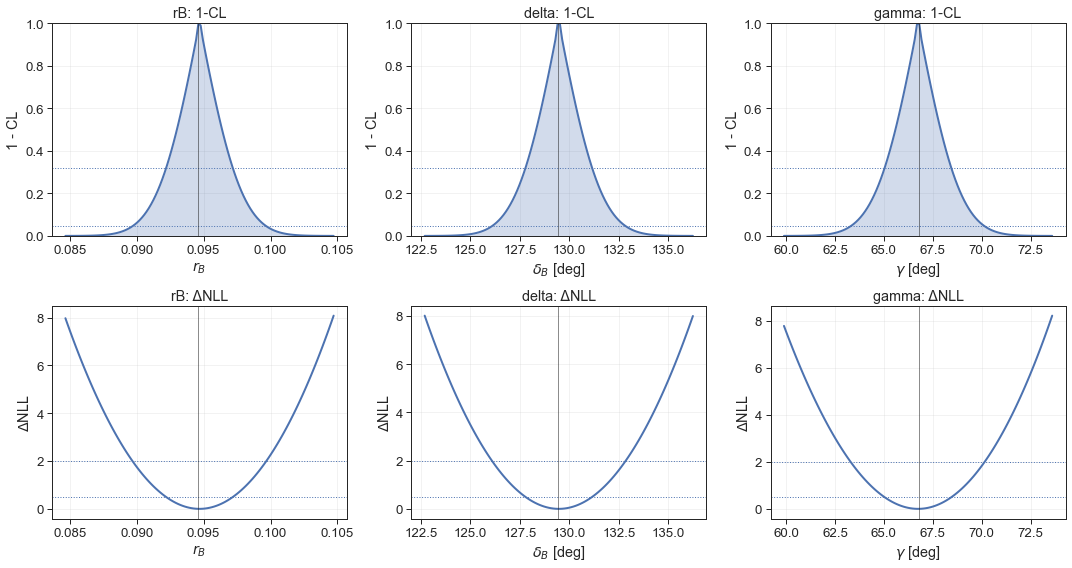

In [139]:
"""
RUNNING BLOCK: Profile-likelihood 1D scans for (rB, delta, gamma)
===============================================================

- Assumes you already have a fitted Minuit object `m` (m.migrad() done).
- You have an extra nuisance parameter `alpha_pF` in the fit, but we do NOT scan it.
- During scans of rB/delta/gamma, alpha_pF is automatically profiled (kept free).

This block:
1) Builds 1D profile scans (mnprofile) for rB, delta, gamma
2) Extracts 68.3% CL (1σ) asymmetric intervals from ΔNLL threshold=0.5
3) Plots LHCb-style 1-CL curves (linear scale) and ΔNLL curves
4) Saves PNG/PDF
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# -----------------------------
# CL utilities (Wilks)
# -----------------------------
CL_1SIGMA = 0.6827
CL_2SIGMA = 0.9545
m = m_ensemble

def delta_nll_to_confidence_level(delta_nll, ndof=1):
    delta_chi2 = 2.0 * np.asarray(delta_nll)
    return stats.chi2.cdf(delta_chi2, df=ndof)

def confidence_level_to_delta_nll(cl, ndof=1):
    delta_chi2 = stats.chi2.ppf(cl, df=ndof)
    return delta_chi2 / 2.0

def profile_likelihood_scan_1d(minuit, param, bounds=None, npoints=100, subtract_min=True):
    best_val = minuit.values[param]
    best_err = minuit.errors[param]

    # Robust fallback bounds if Hesse error missing/zero
    if bounds is None:
        if (best_err is None) or (not np.isfinite(best_err)) or (best_err <= 0):
            # fallback: use limits if present, else a small window around best
            lim = minuit.limits[param]
            if lim is not None and all(v is not None for v in lim):
                bounds = (lim[0], lim[1])
            else:
                bounds = (best_val - 1.0, best_val + 1.0)
        else:
            bounds = (best_val - 4 * best_err, best_val + 4 * best_err)

    # Minuit's built-in profile scan (profiles all other free params, incl alpha_pF)
    x, y, success = minuit.mnprofile(param, bound=bounds, size=npoints, subtract_min=subtract_min)

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)

    if subtract_min:
        delta_nll = y
        nll_min = minuit.fval
        nll = y + nll_min
    else:
        nll = y
        nll_min = np.nanmin(nll)
        delta_nll = nll - nll_min

    cl = delta_nll_to_confidence_level(delta_nll, ndof=1)

    return {
        "param_values": x,
        "nll": nll,
        "delta_nll": delta_nll,
        "cl": cl,
        "one_minus_cl": 1.0 - cl,
        "best_fit": best_val,
        "best_err": best_err,
        "nll_min": nll_min,
        "success": np.array(success, dtype=bool),
        "bounds": bounds,
    }

def extract_confidence_interval(scan_result, cl=CL_1SIGMA):
    x = scan_result["param_values"]
    dnll = scan_result["delta_nll"]

    best_idx = int(np.nanargmin(dnll))
    best_fit = float(x[best_idx])

    thr = confidence_level_to_delta_nll(cl, ndof=1)  # e.g. 0.5 for 68.3%

    # --- lower side
    xl = x[: best_idx + 1]
    yl = dnll[: best_idx + 1]

    if np.any(yl > thr):
        idx = np.where(yl > thr)[0][-1]
        if idx < len(xl) - 1:
            x1, x2 = xl[idx], xl[idx + 1]
            y1, y2 = yl[idx], yl[idx + 1]
            lower_bound = x1 + (thr - y1) * (x2 - x1) / (y2 - y1)
        else:
            lower_bound = xl[idx]
    else:
        lower_bound = xl[0]

    # --- upper side
    xu = x[best_idx:]
    yu = dnll[best_idx:]

    if np.any(yu > thr):
        idx = np.where(yu > thr)[0][0]
        if idx > 0:
            x1, x2 = xu[idx - 1], xu[idx]
            y1, y2 = yu[idx - 1], yu[idx]
            upper_bound = x1 + (thr - y1) * (x2 - x1) / (y2 - y1)
        else:
            upper_bound = xu[idx]
    else:
        upper_bound = xu[-1]

    return best_fit, best_fit - lower_bound, upper_bound - best_fit, (lower_bound, upper_bound)

def plot_1d_profile_scan(scan_result, param_label, true_value=None, ax=None, plot_style="lhcb"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    x = scan_result["param_values"]

    if plot_style == "lhcb":
        y = scan_result["one_minus_cl"]
        ax.plot(x, y, lw=2)
        ax.fill_between(x, 0, y, alpha=0.25)

        ax.axhline(1 - CL_1SIGMA, ls=":", lw=1)
        ax.axhline(1 - CL_2SIGMA, ls=":", lw=1)
        ax.set_ylim(0.0, 1.0)
        ax.set_ylabel("1 - CL")
    else:
        y = scan_result["delta_nll"]
        ax.plot(x, y, lw=2)
        ax.axhline(confidence_level_to_delta_nll(CL_1SIGMA), ls=":", lw=1)  # 0.5
        ax.axhline(confidence_level_to_delta_nll(CL_2SIGMA), ls=":", lw=1)  # 2.0
        ax.set_ylabel(r"$\Delta$NLL")

    # Best fit marker (from scan array)
    best_idx = int(np.nanargmin(scan_result["delta_nll"]))
    ax.axvline(x[best_idx], color="k", lw=1, alpha=0.5)

    if true_value is not None:
        ax.axvline(true_value, color="r", ls="--", lw=1.5, label="True value")
        ax.legend(loc="best", fontsize=9)

    ax.set_xlabel(param_label)
    ax.grid(True, alpha=0.3)
    return ax

# -----------------------------
# MAIN: scan and plot
# -----------------------------
# Assumes `m` exists and is already fitted. Example parameter names:
#   rB, delta, gamma, alpha_pF
# We scan only rB, delta, gamma.
params = ["rB", "delta", "gamma"]

labels = {
    "rB": r"$r_B$",
    "delta": r"$\delta_B$ [deg]",
    "gamma": r"$\gamma$ [deg]",
}

# Optional true values dict (leave empty if you don't have them)
true_vals = {}  # e.g. {"gamma": 70.0, "delta": 130.0, "rB": 0.1}

# Choose explicit bounds (recommended) or set to None to use ±4σ from Minuit errors
scan_bounds = {
    # "rB": (0.0, 0.3),
    # "delta": (120.0, 140.0),
    # "gamma": (60.0, 80.0),
}

npoints = 120

# Ensure the nuisance parameter is free during scans (profiled automatically)
if "alpha_pF" in m.parameters:
    m.fixed["alpha_pF"] = False

scans = {}
intervals_1sigma = {}

for p in params:
    scans[p] = profile_likelihood_scan_1d(
        m,
        p,
        bounds=scan_bounds.get(p, None),
        npoints=npoints,
        subtract_min=True,
    )
    best, lo, hi, (lb, ub) = extract_confidence_interval(scans[p], cl=CL_1SIGMA)
    intervals_1sigma[p] = (best, lo, hi, lb, ub)

print("\n" + "=" * 70)
print("Profile likelihood intervals (68.3% CL, ΔNLL=0.5)")
print("=" * 70)
for p in params:
    best, lo, hi, lb, ub = intervals_1sigma[p]
    unit = " deg" if p in ("delta", "gamma") else ""
    print(f"{p:6s} = {best:10.4f} +{hi:.4f} -{lo:.4f}{unit}   [{lb:.4f}, {ub:.4f}]")
print("=" * 70)

# --- Plot: LHCb-style 1-CL and ΔNLL side-by-side
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, p in enumerate(params):
    plot_1d_profile_scan(
        scans[p],
        labels.get(p, p),
        true_value=true_vals.get(p, None),
        ax=axes[0, i],
        plot_style="lhcb",
    )
    axes[0, i].set_title(f"{p}: 1-CL")

    plot_1d_profile_scan(
        scans[p],
        labels.get(p, p),
        true_value=true_vals.get(p, None),
        ax=axes[1, i],
        plot_style="delta_nll",
    )
    axes[1, i].set_title(f"{p}: ΔNLL")

plt.tight_layout()
fig.savefig("profile_scans_rB_delta_gamma.png", dpi=150, bbox_inches="tight")
fig.savefig("profile_scans_rB_delta_gamma.pdf", bbox_inches="tight")
print("\nSaved: profile_scans_rB_delta_gamma.png / .pdf")


---

### Summary: Ensemble-Based Uncertainty Quantification

This section implements a rigorous approach to account for **model uncertainty in D decay** when extracting CP violation parameters (r_B, δ_B, γ) from B± → DK± decays.

#### Key Methodology:

1. **Ensemble of Normalizing Flows**  
   - Train 25 independent flow models on D → K⁻π⁺π⁰ decay data
   - Each model provides a different representation of |A_D|²
   - Ensemble diversity captures model uncertainty

2. **Per-Event Statistics**  
   - For each event in B± data, compute pF from all 25 models
   - Calculate per-event mean: $\bar{p}_F = \frac{1}{25}\sum_{i=1}^{25} p_{F,i}$
   - Calculate per-event std: $\sigma_{p_F} = \sqrt{\frac{1}{24}\sum_{i=1}^{25}(p_{F,i} - \bar{p}_F)^2}$

3. **Nuisance Parameter Approach**  
   - Introduce α_pF as a **nuisance parameter** in the likelihood
   - Shift pF by ensemble uncertainty: $p_F^{\text{shifted}} = \bar{p}_F + \alpha_{p_F} \cdot \sigma_{p_F}$
   - Add Gaussian constraint: $\mathcal{L}_{\text{constraint}} = e^{-\frac{1}{2}\alpha_{p_F}^2}$
   - This penalizes large deviations but allows data-driven shifts

4. **Profile Likelihood**  
   - When scanning γ (or other parameters), α_pF is profiled (minimized at each point)
   - This incorporates model uncertainty into confidence intervals
   - Final uncertainties include both **statistical** (from data) and **systematic** (from model) components

#### Advantages:

- **Theoretically motivated**: Treats model uncertainty as a nuisance parameter (standard in HEP)
- **Data-driven**: The fit determines how much to shift pF based on likelihood
- **Computationally efficient**: Only compute ensemble statistics once, not 25 separate fits
- **Unified uncertainties**: Profile likelihood naturally combines statistical + systematic errors

#### Comparison to Bootstrap:

Traditional bootstrap would fit 25 times (once per model) and combine results afterward. The nuisance parameter approach is equivalent but more elegant:

| Aspect | Bootstrap | Nuisance Parameter |
|--------|-----------|--------------------|
| Fits required | 25 | 1 |
| Profile scans | 25 × N_points | 1 × N_points |
| Error combination | Post-hoc | Automatic (via profiling) |
| Interpretation | Spread of results | Constrained variation |

#### Extension to CP-even/odd Flows:

The current implementation uses a single model for flow_even and flow_odd (for C and S terms). To fully account for D decay uncertainty, one could:

1. Train ensembles for flow_even and flow_odd as well
2. Introduce additional nuisance parameters: α_even, α_odd
3. Shift interference terms: $C^{\text{shifted}} = \bar{C} + \alpha_{even} \cdot \sigma_C$

This is left as a future extension if C/S uncertainties are significant.

#### References:

- Nuisance parameter profiling: PDG Statistics Review (2023)
- Normalizing flows for HEP: Papamakarios et al., arXiv:1906.04032
- GGSZ method: Giri & Grossman, PRD 68 (2003) 054018; Bondar, PLB 624 (2005) 134


---

### Summary: Ensemble-Based Uncertainty Quantification

This section implements a rigorous approach to account for **model uncertainty in D decay** when extracting CP violation parameters (r_B, δ_B, γ) from B± → DK± decays.

#### Key Methodology:

1. **Ensemble of Normalizing Flows**  
   - Train 25 independent flow models on D → K⁻π⁺π⁰ decay data
   - Each model provides a different representation of |A_D|²
   - Ensemble diversity captures model uncertainty

2. **Per-Event Statistics via `compute_interference_terms_ensemble()`**  
   - For each dataset (data B±, MC B±), compute pF and pFsw from all 25 models
   - Calculate per-event mean and std:
     - $\bar{p}_F = \frac{1}{25}\sum_{i=1}^{25} p_{F,i}$, $\sigma_{p_F} = \text{std}(p_{F,i})$
     - $\bar{p}_{F}^{\text{sw}} = \frac{1}{25}\sum_{i=1}^{25} p_{F,i}^{\text{sw}}$, $\sigma_{p_{F}^{\text{sw}}} = \text{std}(p_{F,i}^{\text{sw}})$
   - Compute C, S terms separately using single flow models (flow_even, flow_odd)

3. **Single Nuisance Parameter Approach**  
   - Introduce **one nuisance parameter** α_pF in the likelihood
   - The **same** α_pF shifts both pF and pFsw (correlated uncertainty):
     - $p_F^{\text{shifted}} = \bar{p}_F + \alpha_{p_F} \cdot \sigma_{p_F}$
     - $p_{F}^{\text{sw, shifted}} = \bar{p}_{F}^{\text{sw}} + \alpha_{p_F} \cdot \sigma_{p_{F}^{\text{sw}}}$
   - Add Gaussian constraint: $\mathcal{L}_{\text{constraint}} = e^{-\frac{1}{2}\alpha_{p_F}^2}$
   - This penalizes large deviations but allows data-driven shifts

4. **Physical Interpretation**
   - α_pF = 0: Use ensemble mean (average model)
   - α_pF = +1: Shift toward models predicting higher density everywhere
   - α_pF = -1: Shift toward models predicting lower density everywhere
   - The fit finds which "version" of the model best describes the data

5. **Profile Likelihood**  
   - When scanning γ (or other parameters), α_pF is profiled (minimized at each point)
   - This incorporates model uncertainty into confidence intervals
   - Final uncertainties include both **statistical** (from data) and **systematic** (from model) components

#### Key Functions:

```python
# 1. Load ensemble
flow_ensemble = load_ensemble_flows('test_ensemble2', num_flows=16, 
                                     hidden_features=128, num_bins=16)

# 2. Compute ensemble statistics (pF and pFsw only)
ens = compute_interference_terms_ensemble(
    points_sdp, flow_ensemble, sdp_obj, idx=(1,2,3)
)
# Returns: pF_mean, pF_std, pFsw_mean, pFsw_std

# 3. Fit with single nuisance parameter
m = fit_with_flow_ensemble(
    dataM_sdp, dataP_sdp, mcM_sdp, mcP_sdp,
    flow_ensemble, flow_even, flow_odd, dkpp_model, ...
)
# Fits: rB, delta, gamma, alpha_pF (4 parameters total)

# 4. Profile scan (profiles alpha_pF)
scan = profile_scan_with_ensemble_uncertainty(m, 'gamma', npoints=50)
plot_profile_scan_with_nuisance(scan, 'γ [deg]')
```

#### Advantages:

- **Physically motivated**: pF and pFsw come from same model → 100% correlated uncertainty
- **Simpler model**: Only 1 nuisance parameter vs 2 (fewer degrees of freedom)
- **Proper handling**: Uses mag_AD_from_flow() for Jacobians and coordinate transformations
- **Consistent with existing code**: C and S still use single flow_even/flow_odd models
- **Computationally efficient**: Compute ensemble statistics once, fit once (not 25 fits)
- **Unified uncertainties**: Profile likelihood combines statistical + systematic naturally

#### Why Single Nuisance Parameter?

Using the same α_pF for both pF and pFsw is correct because:

1. **Same physical source**: Both come from the same flow model ensemble
2. **Correlated errors**: If model i overestimates density, it affects both pF and pFsw
3. **Simpler interpretation**: "Which model does the data prefer?" rather than "How to shift pF and pFsw independently?"
4. **Prevents unphysical scenarios**: Can't have pF shift up while pFsw shifts down from same model

| Aspect | Two Nuisance Params | Single Nuisance Param |
|--------|---------------------|----------------------|
| Physical motivation | Weak | Strong (correlated) |
| DOF in fit | 5 (rB, δ, γ, α_pF, α_pFsw) | 4 (rB, δ, γ, α_pF) |
| Interpretation | Unclear | Clear (model selection) |
| Allows independent shifts | Yes (unphysical) | No (physical) |

#### Comparison to Bootstrap:

Traditional bootstrap would fit 25 times (once per model) and combine results afterward:

| Aspect | Bootstrap | Nuisance Parameter |
|--------|-----------|--------------------|
| Fits required | 25 | 1 |
| Profile scans | 25 × N_points | 1 × N_points |
| Error combination | Post-hoc (RMS spread) | Automatic (via profiling) |
| Interpretation | Spread of results | Constrained variation |
| Computation time | ~25× longer | Fast |

#### Extension to C and S Terms:

The current implementation uses a single model for C and S (interference terms from CP-even/odd flows). To include uncertainty in these terms:

1. Train ensembles for flow_even and flow_odd
2. Compute C_mean, C_std, S_mean, S_std across ensemble
3. Introduce additional nuisance parameter: α_C (same for both C and S, correlated)
4. Shift: $C^{\text{shifted}} = \bar{C} + \alpha_C \cdot \sigma_C$, $S^{\text{shifted}} = \bar{S} + \alpha_C \cdot \sigma_S$

This is left as a future extension if C/S uncertainties become significant.

#### Technical Notes:

- **Ensemble size**: 25 models provide good balance between uncertainty estimation and computation
- **Nuisance parameter limits**: Set to ±5σ to allow sufficient freedom while maintaining stability
- **Gaussian constraint**: Standard deviation of 1 means constraint has comparable weight to ~1 event
- **Physical cuts**: |C| ≤ |A_D|·|A_D_bar| constraint applied before fit (uses first model)
- **C and S**: Computed with first model from ensemble (single flow_even, flow_odd)

#### References:

- Nuisance parameter profiling: PDG Statistics Review (2023)
- Normalizing flows for HEP: Papamakarios et al., arXiv:1906.04032
- GGSZ method: Giri & Grossman, PRD 68 (2003) 054018; Bondar, PLB 624 (2005) 134


In [22]:
from matplotlib.colors import TwoSlopeNorm


def make_sdp_grid(nx=400, ny=400):
    u = np.linspace(0, 1, nx)
    v = np.linspace(0, 1, ny)
    U, V = np.meshgrid(u, v, indexing='xy')
    pts = np.column_stack([U.ravel(), V.ravel()])
    return U, V, pts


def compute_c_exact(pts, sdp_obj, flow, dkpp_model, device=None):
    """
    Compute exact differential C term:
        dC_exact = abJ * cos(delta_phi) 

    Inputs:
      points_sdp : (N,2) SDP points (u,v)
      flow_flavor : flavor flow giving local magnitude + Jacobian
      dkpp_model  : DKpp amplitude model
      sdp_obj     : SDP mapping helper
      idx         : DP index ordering (1,2,3) default
      device      : torch device
      eps         : numerical safety floor

    Returns:
      dC_exact  : array (N,)
      abJ       : array (N,)
    """
    S = sdp_to_dp(pts, sdp_obj)
    s12, s13 = S[:,0], S[:,1] 

    # amplitudes
    A12  = dkpp_model.full(np.column_stack([s12, s13]))
    A13s = dkpp_model.full(np.column_stack([s13, s12]))

    # magnitudes
    mag12 = np.abs(A12)
    mag13 = np.abs(A13s)

    # Jacobian (from your existing code)
    _, invJ = mag_AD_from_flow(pts, flow, sdp_obj, idx = (1,2,3), device=device)
    invJ = _finite_pos(invJ)

    # phases
    phi12 = np.angle(A12)
    phi13 = np.angle(A13s)
    dphi = (phi12 - phi13 + np.pi) % (2*np.pi) - np.pi

    abJ = mag12 * mag13

    dC_exact = abJ * np.cos(dphi) * invJ
    return dC_exact, abJ

def pdf_from_flow(pts, flow, device):
    with torch.no_grad():
        logp = flow.log_prob(torch.from_numpy(pts.astype(np.float32)).to(device))
    return np.exp(logp.cpu().numpy())

def compute_c_flow(pts, flow_plus, flow_minus, 
                   Gamma_plus, Gamma_minus, device=None):

    f_even = pdf_from_flow(pts, flow_plus, device)
    f_odd  = pdf_from_flow(pts, flow_minus, device)

    # physical differential widths
    dGamma_plus  = Gamma_plus  * f_even
    dGamma_minus = Gamma_minus * f_odd

    # unbinned physical c(x)
    c_flow = (dGamma_plus - dGamma_minus)/(Gamma_plus+ Gamma_minus)

    return c_flow

def compare_dC(U, V, dC_flow, dC_exact):
    diff = dC_flow - dC_exact

    vmax = np.nanpercentile(np.abs(dC_exact), 98)
    norm = TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)

    # vmax_diff = np.nanpercentile(np.abs(diff), 98)
    # norm_diff = TwoSlopeNorm(vcenter=0, vmin=-vmax_diff, vmax=vmax_diff)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    axs[0].imshow(dC_flow, origin='lower', extent=[0,1,0,1], norm=norm, cmap='RdBu_r')
    axs[0].set_title("Flow-calibrated $dC_{flow}$")

    axs[1].imshow(dC_exact, origin='lower', extent=[0,1,0,1], norm=norm, cmap='RdBu_r')
    axs[1].set_title("Amplitude $dC_{exact}$")

    im = axs[2].imshow(diff, origin='lower', extent=[0,1,0,1], norm=norm, cmap='RdBu_r')
    axs[2].set_title("Difference $dC_{flow}-dC_{exact}$")

    fig.colorbar(im, ax=axs, shrink=0.8)
    plt.show()



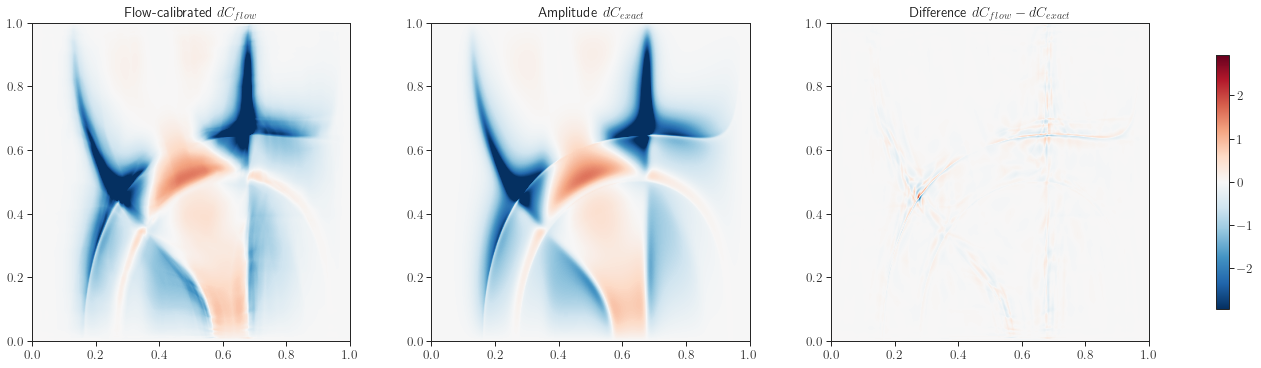

In [23]:
U, V, pts = make_sdp_grid(400, 400)

dC_exact, abJ = compute_c_exact(pts, sdp_obj, flow, dkpp,
                    device=None)

dC_flow_cal= compute_c_flow(pts, flow_even, flow_odd, 
                   gamma_p, gamma_m, device=None)

# Optional: ignore tiny bins
mask = (abJ > 1e-6)

# reshape for plotting
NY, NX = U.shape
dC_exact_img = dC_exact.reshape(NY, NX)
dC_flow_img  = dC_flow_cal.reshape(NY, NX)

compare_dC(U, V, dC_flow_img, dC_exact_img*4/(gamma_p + gamma_m))

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_C_comparison_mtheta(
    C_flow,
    C_exact,
    *,
    extent=(0, 1, 0, 1),
    cmap="RdBu_r",            # back to previous scheme
    percentile=98,
    flow_title=r"Normalizing-flow estimate: $\mathcal{C}_{\mathrm{flow}}(m',\theta')$",
    exact_title=r"Isobar-model prediction: $\mathcal{C}_{\mathrm{exact}}(m',\theta')$",
    xlabel=r"$m'$",
    ylabel=r"$\theta'$",
    figsize=(12, 4.8),
    dpi=200,
    savepath=None,
):
    """
    Side-by-side comparison of C(m', theta') from a normalizing flow vs exact isobar model.
    - Shared robust, symmetric color normalization (centered at 0)
    - No colorbar
    - y-axis label shown on BOTH panels
    """

    # Robust symmetric color scale shared across panels
    ref = np.concatenate([np.ravel(C_exact), np.ravel(C_flow)])
    ref = ref[np.isfinite(ref)]
    vmax = np.nanpercentile(np.abs(ref), percentile) if ref.size else 1.0
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)

    fig, axs = plt.subplots(1, 2, figsize=figsize, constrained_layout=True, dpi=dpi)

    axs[0].imshow(
        C_flow, origin="lower", extent=extent, norm=norm, cmap=cmap,
        interpolation="nearest", aspect="equal"
    )
    axs[0].set_title(flow_title, pad=8)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].imshow(
        C_exact, origin="lower", extent=extent, norm=norm, cmap=cmap,
        interpolation="nearest", aspect="equal"
    )
    axs[1].set_title(exact_title, pad=8)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    # Subpanel labels
    axs[0].text(0.02, 0.98, "(a)", transform=axs[0].transAxes, va="top", ha="left")
    axs[1].text(0.02, 0.98, "(b)", transform=axs[1].transAxes, va="top", ha="left")

    # Paper-style ticks/spines
    for ax in axs:
        ax.tick_params(direction="out", length=3, width=0.8)
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
    return fig, axs


(<Figure size 3600x1500 with 2 Axes>,
 array([<Axes: title={'center': "Normalizing-flow estimate: $\\mathcal{C}_{\\mathrm{flow}}(m',\\theta')$"}, xlabel="$m'$", ylabel="$\\theta'$">,
        <Axes: title={'center': "Isobar-model prediction: $\\mathcal{C}_{\\mathrm{exact}}(m',\\theta')$"}, xlabel="$m'$", ylabel="$\\theta'$">],
       dtype=object))

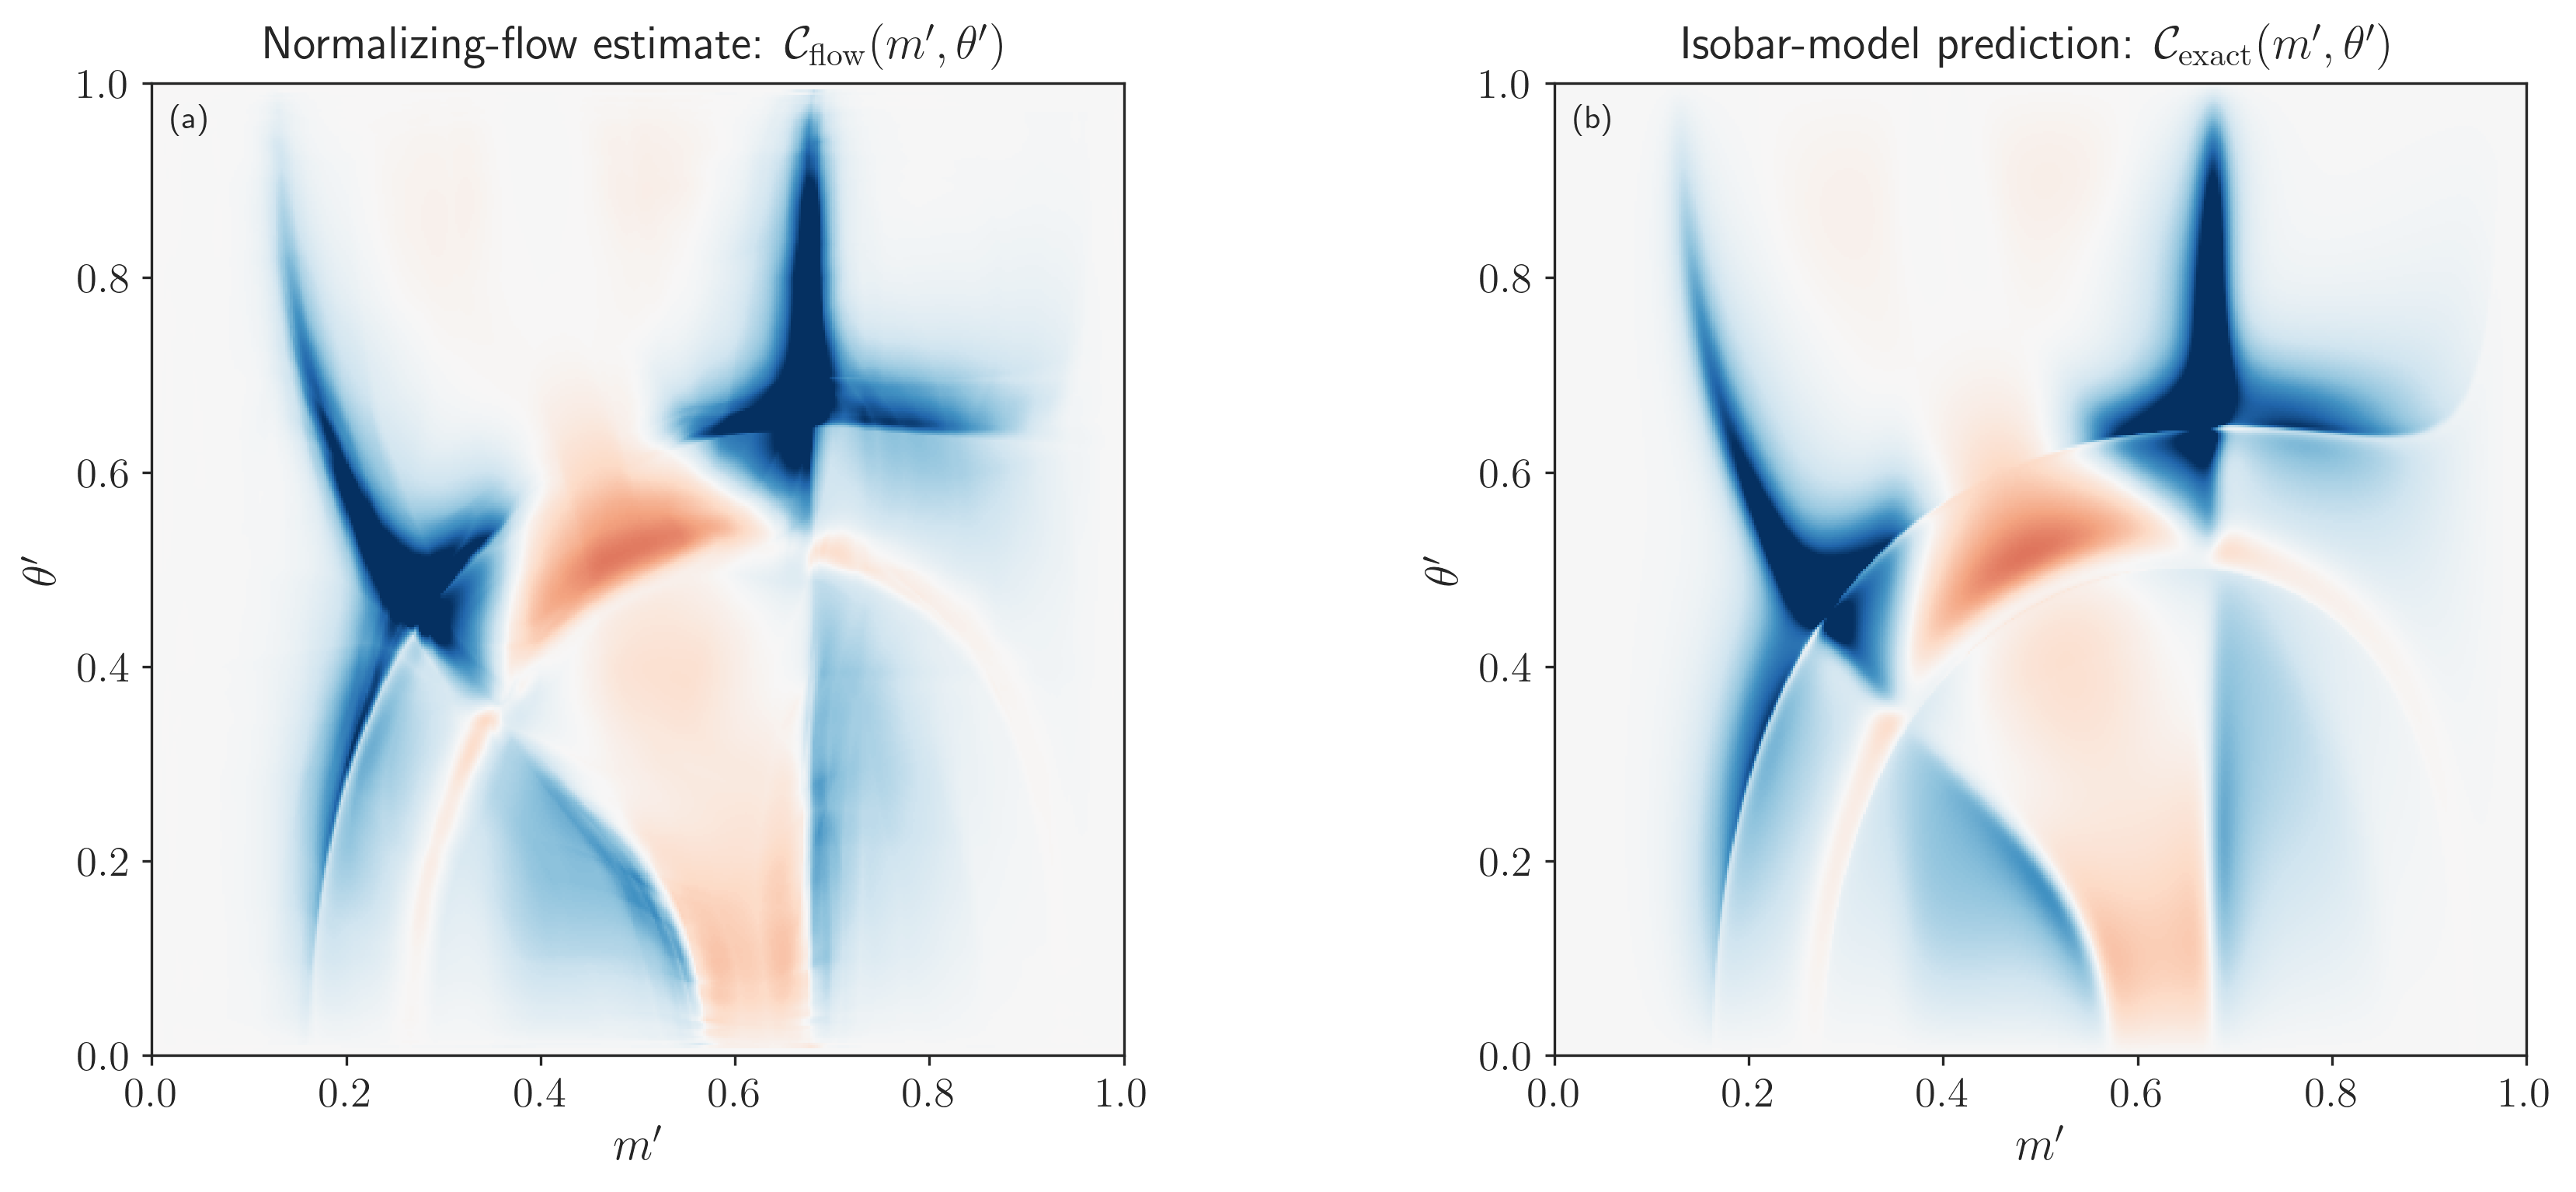

In [25]:
plot_C_comparison_mtheta(
    C_flow=dC_flow_img,
    C_exact=dC_exact_img * 4 / (gamma_p + gamma_m),
    extent=(0, 1, 0, 1),
    figsize=(12, 5),
    dpi=300,
    savepath="C_comparison_mtheta.pdf",
)

In [27]:
# Load the amplitude model

"""
--- MODEL 5 (The Champion)
# Hyperparameters
n_blocks = 12
n_bins = 25
hidden_features = 128

# Training details
batch_size = 50000
epochs = 130
scheduler: ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=3, min_lr=1e-6)
learning_rate_init = 0.009
patience = 3
factor = 0.9
min_learning_rate = 1e-6

NLL loss minimum (at the end of training): -1.253 (-1.254 global minimum during training)
Total parameters: 315768
"""

# Model hyperparameters
n_blocks = 16
n_bins = 16
hidden_features = 128

# Print total number of parameters
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total # of parameters: {total_params}")

# Initialize the model
flow = conjure_flow( num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

# Load the weights
flow.load_state_dict(torch.load('single_model_final.pth'))

# Set the flow to evaluation mode
flow.eval()

Total # of parameters: 365296


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=47, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=47, bias=True)
        )
      )
      (4): Rand

In [26]:
# ============================================================================
# Perform unbinned maximum likelihood fit
# ============================================================================

# Run the fit
m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    # Data samples
    dataM_sdp=dataM_sdp,     # B- experimental data
    dataP_sdp=dataP_sdp,     # B+ experimental data
    mcM_sdp=mcM_sdp,         # B- Monte Carlo
    mcP_sdp=mcP_sdp,         # B+ Monte Carlo
    
    # Amplitude models
    flow_flavor=flow,         # Combined flow (even+odd)
    flow_even=flow_even,      # CP-even flow
    flow_odd=flow_odd,        # CP-odd flow
    dkpp_model=dkpp,          # D -> Kspipi amplitude model
    
    # True values (for comparison)
    true_rB=true_rB,
    true_deltaB=true_deltaB  * 180 / np.pi,
    true_gamma=true_gamma  * 180 / np.pi,
    
    # Configuration
    sdp_obj=sdp_obj,
    idx=(1, 2, 3),
    initial_scale=0.2,        # Starting scale for r_B (relative to true value)
    delta_offset=30,          # Offset in degrees for delta_B initialization
    gamma_offset=30,          # Offset in degrees for gamma initialization
    device=device,
    
    # Normalizations
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,                     
)

# Print results
print(m)

/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


16770 16626
Total fit time: 0.12s

rB    = 0.3014 ± 0.0040
delta = 60.77° ± 0.88°
gamma = 42.53° ± 0.87°
(true rB=0.3000, true γ=40.00°, true δ=60.00°)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5777                       │              Nfcn = 96               │
│ EDM = 1.54e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└───────────

In [28]:
# ============================================================================
# Perform unbinned maximum likelihood fit
# ============================================================================

# Run the fit
m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    # Data samples
    dataM_sdp=dataM_sdp,     # B- experimental data
    dataP_sdp=dataP_sdp,     # B+ experimental data
    mcM_sdp=mcM_sdp,         # B- Monte Carlo
    mcP_sdp=mcP_sdp,         # B+ Monte Carlo
    
    # Amplitude models
    flow_flavor=flow,         # Combined flow (even+odd)
    flow_even=flow_even,      # CP-even flow
    flow_odd=flow_odd,        # CP-odd flow
    dkpp_model=dkpp,          # D -> Kspipi amplitude model
    
    # True values (for comparison)
    true_rB=true_rB,
    true_deltaB=true_deltaB  * 180 / np.pi,
    true_gamma=true_gamma  * 180 / np.pi,
    
    # Configuration
    sdp_obj=sdp_obj,
    idx=(1, 2, 3),
    initial_scale=0.2,        # Starting scale for r_B (relative to true value)
    delta_offset=30,          # Offset in degrees for delta_B initialization
    gamma_offset=30,          # Offset in degrees for gamma initialization
    device=device,
    
    # Normalizations
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,                     
)

# Print results
print(m)

16882 16745
Total fit time: 0.14s

rB    = 0.2984 ± 0.0042
delta = 60.47° ± 0.78°
gamma = 42.08° ± 0.78°
(true rB=0.3000, true γ=40.00°, true δ=60.00°)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6660                       │              Nfcn = 104              │
│ EDM = 3.18e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└───────────

In [32]:
# Load the amplitude model

"""
--- MODEL 5 (The Champion)
# Hyperparameters
n_blocks = 12
n_bins = 25
hidden_features = 128

# Training details
batch_size = 50000
epochs = 130
scheduler: ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=3, min_lr=1e-6)
learning_rate_init = 0.009
patience = 3
factor = 0.9
min_learning_rate = 1e-6

NLL loss minimum (at the end of training): -1.253 (-1.254 global minimum during training)
Total parameters: 315768
"""

# Model hyperparameters
n_blocks = 16
n_bins = 16
hidden_features = 128

# Print total number of parameters
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total # of parameters: {total_params}")

# Initialize the model
flow = conjure_flow( num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)



# Load the checkpoint
checkpoint = torch.load('single_model_best.pth')

# Extract just the model weights
flow.load_state_dict(checkpoint['model_state_dict'])  # ← Note the key!
flow.eval()

Total # of parameters: 365296


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=47, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=47, bias=True)
        )
      )
      (4): Rand

In [33]:
# ============================================================================
# Perform unbinned maximum likelihood fit
# ============================================================================

# Run the fit
m = fit_rB_delta_gamma_SDP_unbinned_jac_terms_flowDC(
    # Data samples
    dataM_sdp=dataM_sdp,     # B- experimental data
    dataP_sdp=dataP_sdp,     # B+ experimental data
    mcM_sdp=mcM_sdp,         # B- Monte Carlo
    mcP_sdp=mcP_sdp,         # B+ Monte Carlo
    
    # Amplitude models
    flow_flavor=flow,         # Combined flow (even+odd)
    flow_even=flow_even,      # CP-even flow
    flow_odd=flow_odd,        # CP-odd flow
    dkpp_model=dkpp,          # D -> Kspipi amplitude model
    
    # True values (for comparison)
    true_rB=true_rB,
    true_deltaB=true_deltaB  * 180 / np.pi,
    true_gamma=true_gamma  * 180 / np.pi,
    
    # Configuration
    sdp_obj=sdp_obj,
    idx=(1, 2, 3),
    initial_scale=0.2,        # Starting scale for r_B (relative to true value)
    delta_offset=30,          # Offset in degrees for delta_B initialization
    gamma_offset=30,          # Offset in degrees for gamma initialization
    device=device,
    
    # Normalizations
    Gamma_minus=gamma_m,
    Gamma_plus=gamma_p,                     
)

# Print results
print(m)

16882 16745
Total fit time: 0.12s

rB    = 0.2984 ± 0.0042
delta = 60.47° ± 0.78°
gamma = 42.08° ± 0.78°
(true rB=0.3000, true γ=40.00°, true δ=60.00°)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6660                       │              Nfcn = 104              │
│ EDM = 3.18e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└───────────